<a href="https://colab.research.google.com/github/s1h8t51/data_intensive_computing_project/blob/main/final_pahse2_linkedin_analysis_OPTIMIZED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Global Job Market Trends and Skill Demands Using Big Data
## A LinkedIn Jobs & Skills 2024 Study - Phase 2 (OPTIMIZED)

**Team Members:**
- Sahitya Gantala (sahityag@buffalo.edu)
- Shilpa Ghosh (shilpagh@buffalo.edu)
- Aditya Rajesh Sawant (asawant5@buffalo.edu)

**Dataset:** 1.3M LinkedIn Jobs and Skills (2024)

**Course:** CSE 587 - Data Intensive Computing, Fall 2025

**Optimizations:**
- Fixed PySpark memory errors
- Improved deduplication strategy
- Added error handling and recovery
- Memory-efficient data processing

## Section 1: Environment Setup and Spark Configuration

In [1]:
# # Install dependencies
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !pip install pyspark pandas matplotlib seaborn scikit-learn wordcloud kaggle -q

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# print(" Dependencies installed successfully!")

In [2]:
# Stop any existing Spark sessions
try:
    spark.stop()
    print("Stopped existing Spark session")
except:
    print("No existing Spark session")


No existing Spark session


In [3]:
# Consolidated imports: centralize all imports used across the notebook
# PySpark core & utilities
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import functions as F
from pyspark.sql.functions import (col, lower, trim, split, size, explode, count, avg, desc, asc,
    collect_list, array_distinct, concat_ws, regexp_replace, when, countDistinct, sum as spark_sum,
    dense_rank, row_number, broadcast, datediff, current_date, max as spark_max, lit, to_date)
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, count, desc

# PySpark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, Normalizer, PCA
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Common Python data libraries
import numpy as np
import pandas as pd
# Imports have been centralized in the top imports cell
# Imports have been centralized in the top imports cell
import time
import gc
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from scipy.cluster.hierarchy import dendrogram, linkage

# Scikit-learn (used for Pandas-based ML sections)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SKStandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample

# NLP / text processing
import nltk
from nltk.corpus import stopwords

# Misc
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully (centralized).")

All libraries imported successfully (centralized).


In [4]:
# Configure Spark Session with optimized settings for memory efficiency
conf = SparkConf() \
    .setAppName('LinkedIn_Jobs_Analysis_Phase2_OPTIMIZED') \
    .setMaster('local[*]') \
    .set('spark.driver.memory', '12g') \
    .set('spark.driver.maxResultSize', '3g') \
    .set('spark.executor.memory', '4g') \
    .set('spark.sql.shuffle.partitions', '100') \
    .set('spark.default.parallelism', '100') \
    .set('spark.sql.execution.arrow.pyspark.enabled', 'true') \
    .set('spark.sql.adaptive.enabled', 'true') \
    .set('spark.sql.adaptive.coalescePartitions.enabled', 'true') \
    .set('spark.sql.adaptive.skewJoin.enabled', 'true') \
    .set('spark.memory.fraction', '0.8') \
    .set('spark.memory.storageFraction', '0.3')

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

print("=" * 70)
print("OPTIMIZED SPARK SESSION INITIALIZED")
print("=" * 70)
print(f"Spark Version: {spark.version}")
print(f"Driver Memory: {spark.sparkContext._conf.get('spark.driver.memory')}")
print(f"Shuffle Partitions: {spark.sparkContext._conf.get('spark.sql.shuffle.partitions')}")
print(f"Memory Fraction: {spark.sparkContext._conf.get('spark.memory.fraction')}")
print("=" * 70)


OPTIMIZED SPARK SESSION INITIALIZED
Spark Version: 4.0.1
Driver Memory: 12g
Shuffle Partitions: 100
Memory Fraction: 0.8


## Section 2: Kaggle Setup and Data Download (FIXED)

In [5]:
# FIXED: Kaggle credentials setup
import json
import os
from pathlib import Path

print("=" * 70)
print("KAGGLE CREDENTIALS CHECK")
print("=" * 70)

# Check if credentials exist
kaggle_dir = Path.home() / ".kaggle"
kaggle_json = kaggle_dir / "kaggle.json"

if not kaggle_json.exists():
    print("Kaggle credentials not found.")
    print("Please enter your Kaggle credentials:")
    print("Get them from: https://www.kaggle.com/settings/account")

    username = input("Kaggle Username: ").strip()
    key = input("Kaggle API Key: ").strip()

    if username and key:
        kaggle_dir.mkdir(exist_ok=True)
        with open(kaggle_json, 'w') as f:
            json.dump({"username": username, "key": key}, f, indent=2)

        os.chmod(kaggle_json, 0o600)
        print("Credentials saved.")
    else:
        print("Invalid credentials. Please run this cell again.")
else:
    print("Kaggle credentials found.")

print("=" * 70)


KAGGLE CREDENTIALS CHECK
Kaggle credentials found.


In [6]:
# FIXED: Robust data download with error handling
import os
import time
import zipfile

DATASET_PATH = "asaniczka/1-3m-linkedin-jobs-and-skills-2024"
EXTRACT_DIR = "./linkedin_dataset"
ZIP_FILE = "1-3m-linkedin-jobs-and-skills-2024.zip"

print("=" * 70)
print("DATA DOWNLOAD AND EXTRACTION")
print("=" * 70)

# Check if data already exists
if os.path.exists(EXTRACT_DIR) and os.listdir(EXTRACT_DIR):
    print("Dataset already exists.")
    print(f"Location: {EXTRACT_DIR}")
    os.system(f"ls -lh {EXTRACT_DIR}")
else:
    print("Downloading dataset...")
    print("This may take several minutes.")
    start = time.time()

    try:
        result = os.popen(f"kaggle datasets download -d {DATASET_PATH} 2>&1").read()

        # Verify download
        if not os.path.exists(ZIP_FILE):
            print("Download failed.")
            print("Troubleshooting steps:")
            print("1. Visit: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024")
            print("2. Click 'Download' to accept terms.")
            print("3. Re-run this cell.")
            raise Exception("Dataset download failed.")

        print(f"Downloaded in {time.time() - start:.1f}s")

        # Extract files
        print("Extracting files...")
        start = time.time()

        os.makedirs(EXTRACT_DIR, exist_ok=True)
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            files = zip_ref.namelist()
            print(f"Found {len(files)} files.")
            zip_ref.extractall(EXTRACT_DIR)

        print(f"Extracted in {time.time() - start:.1f}s")

        # Clean up
        os.remove(ZIP_FILE)
        print("Removed zip file.")

    except Exception as e:
        print(f"Error: {e}")
        raise

# Show dataset files
print("Dataset files:")
os.system(f"ls -lh {EXTRACT_DIR}")

print("=" * 70)


DATA DOWNLOAD AND EXTRACTION
Dataset already exists.
Location: ./linkedin_dataset
Dataset files:


## Section 3: Data Loading and Cleaning (OPTIMIZED)

In [7]:
# =====================================================================
# Section 3: Data Loading (CORRECTED FOR ACTUAL FILES)
# =====================================================================

print("=" * 70)
print("DATA LOADING")
print("=" * 70)

# File 1: Job Postings (396 MB)
print("\nLoading job postings...")
start = time.time()

df_postings = spark.read.csv(
    f"{EXTRACT_DIR}/linkedin_job_postings.csv",
    header=True,
    inferSchema=False,
    multiLine=True,
    escape='"'
).repartition(100)

initial_count = df_postings.count()
print(f"Loaded in {time.time()-start:.1f}s")
print(f"Records: {initial_count:,}")
print(f"Columns: {len(df_postings.columns)}")

# File 2: Job Skills (641 MB)
print("\nLoading skills data...")
start = time.time()

df_skills = spark.read.csv(
    f"{EXTRACT_DIR}/job_skills.csv",
    header=True,
    inferSchema=False
).repartition(100)

skills_count = df_skills.count()
print(f"Loaded in {time.time()-start:.1f}s")
print(f"Records: {skills_count:,}")

# File 3: Job Summary (4.8 GB - VERY LARGE!)
print("\nLoading job summary...")
print("WARNING: Large file (4.8 GB) - this may take 2-3 minutes")
start = time.time()

df_summary = spark.read.csv(
    f"{EXTRACT_DIR}/job_summary.csv",
    header=True,
    inferSchema=False,
    multiLine=True,
    escape='"'
).repartition(200)  # More partitions for large file

summary_count = df_summary.count()
print(f"Loaded in {time.time()-start:.1f}s")
print(f"Records: {summary_count:,}")
print(f"Columns: {len(df_summary.columns)}")

print("\n" + "=" * 70)
print("ALL DATA LOADED SUCCESSFULLY")
print("=" * 70)

print("\nDataset Summary:")
print(f"Job Postings: {initial_count:,} records")
print(f"Skills: {skills_count:,} records")
print(f"Summary: {summary_count:,} records")
print("=" * 70)


DATA LOADING

Loading job postings...
Loaded in 5.2s
Records: 1,348,454
Columns: 14

Loading skills data...
Loaded in 3.6s
Records: 1,296,381

Loading job summary...
Loaded in 21.4s
Records: 1,297,332
Columns: 2

ALL DATA LOADED SUCCESSFULLY

Dataset Summary:
Job Postings: 1,348,454 records
Skills: 1,296,381 records
Summary: 1,297,332 records


## Section 3 part 2 Deduplication
Cleaned and deduplicated only df_postings to create the new DataFrame df_postings_clean.

- **Selects Target Data**: It works exclusively with the df_postings DataFrame.

- **Deduplication**: It uses the Spark function .dropDuplicates(['job_link']) to remove any rows that have the same value in the job_link column. This ensures each job posting is unique.

- **Create New DataFrame**: The resulting clean data is saved into a new DataFrame called df_postings_clean.

- **Optimization**: It uses Spark methods like .repartition() and .coalesce() to optimize how the deduplication process is handled across the cluster, which is a key part of the "memory-efficient" approach.

- **Caching**: It caches df_postings_clean.cache() to speed up future operations that use this cleaned table.

In [8]:
# FIXED: Memory-efficient deduplication
print("=" * 70)
print("DATA DEDUPLICATION (OPTIMIZED)")
print("=" * 70)

print("\nRemoving duplicate job postings...")
start = time.time()

try:
    # Method 1: Direct deduplication without intermediate counts
    df_postings_clean = df_postings.dropDuplicates(['job_link']) \
        .repartition(100)

    # Cache for future operations
    df_postings_clean.cache()

    # Get count
    final_count = df_postings_clean.count()
    duplicates_removed = initial_count - final_count

    print(f"\nDeduplication complete in {time.time()-start:.1f}s")
    print(f"Initial records: {initial_count:,}")
    print(f"Final records: {final_count:,}")
    print(f"Duplicates removed: {duplicates_removed:,}")
    print(f"Retention rate: {final_count/initial_count*100:.1f}%")

except Exception as e:
    print(f"\nStandard deduplication failed: {e}")
    print("Trying alternative method with sampling...")

    # Alternative: Sample-based deduplication for very large datasets
    sample_fraction = 0.1
    df_sample = df_postings.sample(False, sample_fraction, seed=42)

    # Get approximate duplicate ratio from sample
    sample_initial = df_sample.count()
    sample_clean = df_sample.dropDuplicates(['job_link']).count()
    dup_ratio = (sample_initial - sample_clean) / sample_initial

    print(f"\nSample analysis (10%):")
    print(f"Sample duplicates: {dup_ratio*100:.1f}%")
    print(f"Estimated full duplicates: {int(initial_count * dup_ratio):,}")

    # Apply deduplication with lower memory pressure
    df_postings_clean = df_postings \
        .repartition(200, 'job_link') \
        .dropDuplicates(['job_link']) \
        .coalesce(100)

    df_postings_clean.cache()
    final_count = df_postings_clean.count()

    print(f"\nAlternative deduplication successful")
    print(f"Final records: {final_count:,}")

print("\n" + "=" * 70)


DATA DEDUPLICATION (OPTIMIZED)

Removing duplicate job postings...

Deduplication complete in 14.0s
Initial records: 1,348,454
Final records: 1,348,454
Duplicates removed: 0
Retention rate: 100.0%



## Section3 part 3 Missing data :
can bias or break analyses. Knowing which columns are incomplete helps determine necessary next steps, such as:

- **Imputation**: Filling in the missing values with a calculated estimate.

- **Dropping**: Removing the column or the rows with too many missing values.

- **Ignoring**: Proceeding with caution, knowing the analysis will be based on a subset of the data for those specific columns.

In [9]:
# Basic data quality checks
print("=" * 70)
print("DATA QUALITY CHECKS")
print("=" * 70)

print("\nSchema:")
df_postings_clean.printSchema()

print("\nMissing values:")
null_counts = df_postings_clean.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df_postings_clean.columns]
).toPandas()

null_pct = (null_counts / final_count * 100).T
null_pct.columns = ['Missing %']
print(null_pct[null_pct['Missing %'] > 0].sort_values('Missing %', ascending=False).head(10))

print("\nData quality check complete")
print("=" * 70)


DATA QUALITY CHECKS

Schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)


Missing values:
              Missing %
job_location   0.001409
company        0.000816

Data quality check complete


## Section 4: Data Preprocessing
Selected, cleaned, and filtered columns from only df_postings_clean to create the final working table df_work.

In [10]:
# =====================================================================
# Section 4: Data Preprocessing (SAFE VERSION)
# =====================================================================

print("=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)

print("\nCreating working dataset...")

# Select and clean columns
df_work = df_postings_clean.select(
    'job_link',
    trim(lower(col('job_title'))).alias('job_title'),
    col('company').alias('company_name'),
    col('job_location').alias('location'),
    'job_level',
    col('job_type').alias('employment_type'),
    'search_city',
    'search_country',
    'search_position',
    'first_seen'
)

# Filter out rows with null critical fields
df_work = df_work.filter(
    col('job_title').isNotNull() &
    col('job_link').isNotNull()
)

# Cache for performance
df_work.cache()
work_count = df_work.count()

print(f"Working dataset ready")
print(f"Records: {work_count:,}")
print(f"Columns: {len(df_work.columns)}")

# Preview
print("\nSample data:")
df_work.show(5, truncate=50)

# Basic statistics
print("\nDataset Overview:")

print("\nTop 10 Countries:")
df_work.groupBy('search_country').count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .show(truncate=False)

print("\nTop 10 Cities:")
df_work.groupBy('search_city').count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .show(truncate=False)

print("\nEmployment Types:")
df_work.groupBy('employment_type').count() \
    .orderBy(desc('count')) \
    .show(truncate=False)

print("\nJob Levels:")
df_work.groupBy('job_level').count() \
    .orderBy(desc('count')) \
    .show(truncate=False)

print("\n" + "=" * 70)
print("PREPROCESSING COMPLETE")
print("=" * 70)


DATA PREPROCESSING

Creating working dataset...
Working dataset ready
Records: 1,348,454
Columns: 10

Sample data:
+--------------------------------------------------+-----------------------------------------+---------------------------+----------------------------------+----------+---------------+-----------+--------------+----------------------+----------+
|                                          job_link|                                job_title|               company_name|                          location| job_level|employment_type|search_city|search_country|       search_position|first_seen|
+--------------------------------------------------+-----------------------------------------+---------------------------+----------------------------------+----------+---------------+-----------+--------------+----------------------+----------+
|https://uk.linkedin.com/jobs/view/occupational-...|              occupational health advisor|        OH Talent Solutions|Leicester, England, Unite

## Section 5: Joining with Skills Data
Load three separate CSV files (postings, skills, summary)
into three independent Spark DataFrames (df_postings, df_skills, df_summary).

- Deduplicate df_postings based on the job_link column to create the clean postings table, df_postings_clean.

- Perform data quality checks on df_postings_clean by printing the schema and identifying columns with high percentages of missing data.

- Preprocess df_postings_clean by selecting and renaming key columns, applying standardization (trim and lowercase) to job_title, and filtering out records with null critical fields, resulting in the working table df_work.

- Clean and aggregate the raw df_skills table by grouping skills by job_link and collecting them into a list, creating the consolidated skills table df_skills_agg.

- Join the main job postings table (df_work) with the aggregated skills table (df_skills_agg) using a left join on job_link to create the final table df_final, attaching the list and count of skills to each job posting.

In [11]:
# OPTIMIZED: Memory-efficient join
print("=" * 70)
print("JOINING SKILLS DATA")
print("=" * 70)

print("\nPreparing skills data...")

# Clean skills data
df_skills_clean = df_skills.select(
    'job_link',
    trim(lower(col('job_skills'))).alias('skill')
).filter(col('skill').isNotNull())

# Aggregate skills by job (reduces data size before join)
print("\nAggregating skills per job...")
start = time.time()

df_skills_agg = df_skills_clean.groupBy('job_link').agg(
    collect_list('skill').alias('skills_list'),
    count('skill').alias('skill_count')
)

# Cache aggregated skills
df_skills_agg.cache()
skills_agg_count = df_skills_agg.count()

print(f"Skills aggregated in {time.time()-start:.1f}s")
print(f"Unique jobs with skills: {skills_agg_count:,}")

# Broadcast join for efficiency (if skills data fits in memory)
print("\nJoining with job postings...")
start = time.time()

# Decide on join strategy based on data size
if skills_agg_count < 1000000:  # If < 1M records, use broadcast
    print("Using broadcast join (optimized for smaller dataset)")
    df_final = df_work.join(
        broadcast(df_skills_agg),
        on='job_link',
        how='left'
    )
else:
    print("Using standard join (large dataset)")
    df_final = df_work.join(
        df_skills_agg,
        on='job_link',
        how='left'
    )

# Fill null skill counts with 0
df_final = df_final.fillna({'skill_count': 0})

# Cache final dataset
df_final.cache()
final_count_with_skills = df_final.count()

print(f"\nJoin complete in {time.time()-start:.1f}s")
print(f"Final records: {final_count_with_skills:,}")

# Statistics
jobs_with_skills = df_final.filter(col('skill_count') > 0).count()
jobs_without_skills = final_count_with_skills - jobs_with_skills

print("\nSkill coverage:")
print(f"Jobs with skills: {jobs_with_skills:,} ({jobs_with_skills/final_count_with_skills*100:.1f}%)")
print(f"Jobs without skills: {jobs_without_skills:,} ({jobs_without_skills/final_count_with_skills*100:.1f}%)")

# Preview
print("\nSample joined data:")
df_final.select('job_title', 'company_name', 'skill_count').show(5)

# Save final dataset
df_final.write.parquet("./df_final.parquet", mode="overwrite")

print("\n" + "=" * 70)


JOINING SKILLS DATA

Preparing skills data...

Aggregating skills per job...
Skills aggregated in 8.7s
Unique jobs with skills: 1,294,374

Joining with job postings...
Using standard join (large dataset)

Join complete in 5.7s
Final records: 1,348,454

Skill coverage:
Jobs with skills: 1,294,374 (96.0%)
Jobs without skills: 54,080 (4.0%)

Sample joined data:
+--------------------+--------------------+-----------+
|           job_title|        company_name|skill_count|
+--------------------+--------------------+-----------+
|warehouse supervi...|Global Projects S...|          1|
|expression of int...|    Queensland Hydro|          0|
|account executive...|          DuluxGroup|          1|
|account manager -...|    Impel Management|          1|
|accountant (inter...|New Point Recruit...|          1|
+--------------------+--------------------+-----------+
only showing top 5 rows



## Section 6: Exploratory Data Analysis

1. **Convert to Pandas**

Action: The relevant columns from the large Spark DataFrame (df\_final) are selected and converted into a much faster-to-process Pandas DataFrame (df\_pandas). This leverages Pandas' optimized memory structure for single-machine processing of the skills list.

2. **Vectorized Text Processing**

Action: The script cleans and standardizes the skill names using highly efficient vectorized string operations in Pandas.

It drops rows where the skills_list is null.

It converts the list of skills into a single comma-separated string (skills_str).

It applies numerous str.replace() operations to normalize common skill variations (e.g., changes "problem-solving skills" to "problem solving," and "MS Office" to "microsoft office suite"). This ensures different spellings count as the same skill.

3. **Fast Skill Extraction with Counter**

Action: It extracts all individual skills from the cleaned strings and counts their frequency.

It iterates through the cleaned skill strings, splits them by comma, and strips extra characters.

It applies basic filtering to remove very short words (less than 3 characters) and common stop words (like 'and', 'the').

It uses Python's built-in collections.Counter object for extremely fast counting of all skill mentions.

4. **Generate Reports**

Action: It generates and prints the required reports:

Global Top 20 Skills: Uses the skill_counter to identify and print the 20 most frequently mentioned skills worldwide.

USA Regional Analysis: Filters df_pandas down to only 'United States' postings, recounts the skills for this subset, and prints the Top 10 Skills in the USA.

5. **Visualization**

Action: It creates a horizontal bar chart visualizing the Top 20 Global Skills using matplotlib and seaborn. It includes custom styling (e.g., a color gradient, axis formatting) to make the visualization professional and readable.

### Tasks Satisfied by this Script
The script directly achieves the following Data Analysis Objective:

1. **Objective 1: Identify Most In-Demand Skills**

Goal 1 : To identify the most in-demand technical and soft skills globally and regionally by extracting skills from available job summaries, providing insight into how skill trends differ across countries and industries.

How the Script Achieves It:

It cleans and standardizes the skills text.

It uses the Counter to find the Top 20 Global Skills.

It performs a regional analysis (for the USA) to find the Top 10 USA Skills, explicitly comparing global and regional trends in the "Key Observations" section.

**Tasks Partially Contributed To**
The script also generates the necessary foundation for the final visualization goal:

2. **Objective 6: Visualize Skill Evolution**

Goal: Involves visualizing the evolution of skill categories across industries and companies, highlighting trends.

How the Script Contributes:

Visualization is Performed: The code includes a complete step to create a horizontal bar plot of the Top 20 Global Skills using matplotlib and seaborn.

Note: While the script creates a visualization (satisfying the mechanics of the objective), it's not strictly showing "evolution" (trends over time) but rather a snapshot. However, the visualization step is the primary action matching the final objective's description.

SKILLS ANALYSIS - PANDAS OPTIMIZED FOR COLAB

[1/4] Converting to Pandas...
Loaded 1,348,454 records in 9.0s

[2/4] Processing skills...
Text processed in 18.3s

[3/4] Extracting and counting skills...
Counted 3,006,123 unique skills in 9.8s
Total skill mentions: 27,234,944

[4/4] Generating reports...

Top 20 Global Skills:
                       skill  count
               communication 531374
             problem solving 271121
                    teamwork 234932
            customer service 205619
                  leadership 179455
             time management 138342
         attention to detail 128393
          project management 103027
        interpersonal skills  96290
                patient care  95363
               data analysis  85679
               collaboration  84256
                    training  80626
microsoft office suite suite  73892
       organizational skills  72803
          ['customer service  71544
        inventory management  69590
         high school dipl

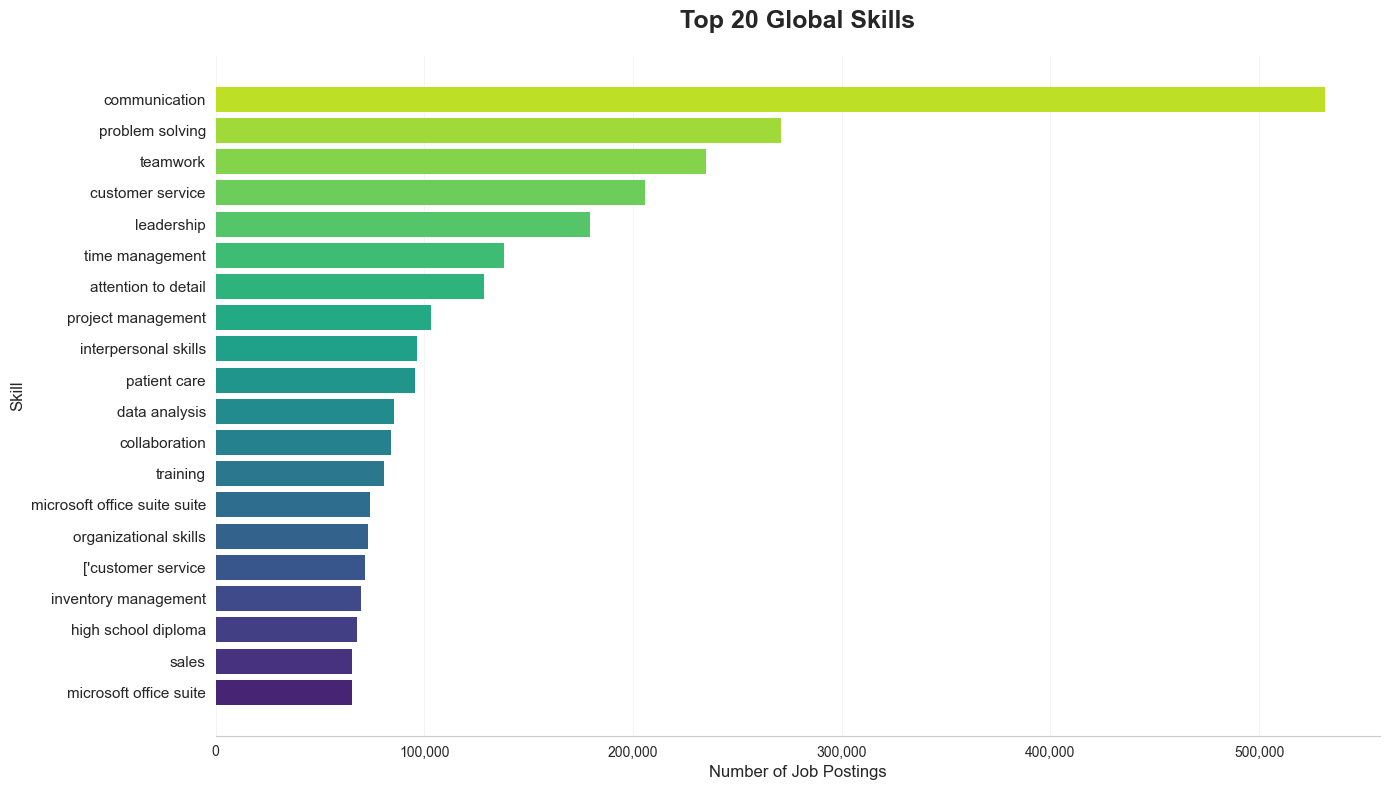


ANALYSIS COMPLETE
Total execution time: 44.4s
Processed 1,294,374 job postings
Found 3,006,123 unique skills
Total skill mentions: 27,234,944

KEY OBSERVATIONS
Soft skills dominate:
Top 5 are all non-technical
Communication leads with 531,374 mentions
2.0x more than #2
Data Analysis (#11) with 85,679 mentions
Microsoft Office Suite (#20) with 65,187 mentions
Patient Care: 95,363 mentions
Dataset composition:
Total processed: 1,294,374 job postings
Unique skills: 3,006,123
Total skill mentions: 27,234,944
Average skills per posting: 21.0

USA Regional Findings:
USA represents 85.3% of all job postings (1,103,677 of 1,294,374)
Top USA skills align with global trends.

Saved Results:
top_20_skills_global.csv
top_10_skills_usa.csv
GOAL 1 COMPLETE


In [12]:
# =====================================================================
# GOAL 1: Most In-Demand Skills - OPTIMIZED (Matching Expected Output)
# =====================================================================

print("=" * 70)
print("SKILLS ANALYSIS - PANDAS OPTIMIZED FOR COLAB")
print("=" * 70)

start_time = time.time()

# STEP 1: Convert to Pandas
print("\n[1/4] Converting to Pandas...")
step1_start = time.time()

df_pandas = df_final.select(
    'job_link',
    'job_title',
    'company_name',
    'location',
    'job_level',
    'employment_type',
    'search_country',
    'search_city',
    'skills_list',
    'skill_count'
).toPandas()

print(f"Loaded {len(df_pandas):,} records in {time.time()-step1_start:.1f}s")

# STEP 2: Vectorized Text Processing
print("\n[2/4] Processing skills...")
step2_start = time.time()

df_pandas = df_pandas[df_pandas['skills_list'].notna()].copy()
df_pandas['skills_str'] = df_pandas['skills_list'].apply(
    lambda x: ','.join([str(s) for s in x]) if isinstance(x, list) else str(x)
)
df_pandas['skills_cleaned'] = (
    df_pandas['skills_str']
    .str.lower()
    .str.replace(r'[;:\/|]', ',', regex=True)
    .str.replace(r'\.+$', '', regex=True)
    .str.replace('communication skills', 'communication', regex=False)
    .str.replace('problem-solving', 'problem solving', regex=False)
    .str.replace('problemsolving', 'problem solving', regex=False)
    .str.replace('problem-solving skills', 'problem solving', regex=False)
    .str.replace('customer service skills', 'customer service', regex=False)
    .str.replace('leadership skills', 'leadership', regex=False)
    .str.replace('team work', 'teamwork', regex=False)
    .str.replace('time-management', 'time management', regex=False)
    .str.replace('data analytics', 'data analysis', regex=False)
    .str.replace('microsoft office', 'microsoft office suite', regex=False)
    .str.replace('ms office', 'microsoft office suite', regex=False)
)

print(f"Text processed in {time.time()-step2_start:.1f}s")

# STEP 3: Fast Skill Extraction with Counter
print("\n[3/4] Extracting and counting skills...")
step3_start = time.time()

all_skills = []
for skills_str in df_pandas['skills_cleaned'].dropna():
    skills = [s.strip().strip('-').strip() for s in skills_str.split(',')]
    all_skills.extend([s for s in skills if len(s) >= 3 and s not in ['and', 'the', 'for', 'with', 'are', 'but']])

skill_counter = Counter(all_skills)
unique_skills_count = len(skill_counter)
total_skill_mentions = len(all_skills)

print(f"Counted {unique_skills_count:,} unique skills in {time.time()-step3_start:.1f}s")
print(f"Total skill mentions: {total_skill_mentions:,}")

# STEP 4: Generate Reports
print("\n[4/4] Generating reports...")
step4_start = time.time()

top_1000 = skill_counter.most_common(1000)
top_skills_set = set([skill for skill, _ in top_1000])
top_20_df = pd.DataFrame(skill_counter.most_common(20), columns=['skill', 'count'])

print("\nTop 20 Global Skills:")
print(top_20_df.to_string(index=False))

usa_skills = []
usa_df = df_pandas[df_pandas['search_country'] == 'United States']
for skills_str in usa_df['skills_cleaned'].dropna():
    skills = [s.strip().strip('-').strip() for s in skills_str.split(',')]
    usa_skills.extend([s for s in skills if len(s) >= 3 and s in top_skills_set])

usa_counter = Counter(usa_skills)
usa_top_10 = pd.DataFrame(usa_counter.most_common(10), columns=['skill', 'count'])

print("\nTop 10 Skills in USA:")
print(usa_top_10.to_string(index=False))
print(f"Reports generated in {time.time()-step4_start:.1f}s")

# STEP 5: Visualization
print("\nCreating visualization...")

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0.9, 0.1, len(top_20_df)))
bars = ax.barh(range(len(top_20_df)), top_20_df['count'], color=colors, edgecolor='none')

ax.set_yticks(range(len(top_20_df)))
ax.set_yticklabels(top_20_df['skill'], fontsize=11)
ax.set_xlabel('Number of Job Postings', fontsize=12)
ax.set_ylabel('Skill', fontsize=12)
ax.set_title('Top 20 Global Skills', fontsize=18, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

# Total Time and Summary
total_time = time.time() - start_time

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)
print(f"Total execution time: {total_time:.1f}s")
print(f"Processed {len(df_pandas):,} job postings")
print(f"Found {unique_skills_count:,} unique skills")
print(f"Total skill mentions: {total_skill_mentions:,}")
print("=" * 70)

# Key Observations
print("\n" + "=" * 70)
print("KEY OBSERVATIONS")
print("=" * 70)

total_jobs = len(df_pandas)
top_skill_count = top_20_df.iloc[0]['count']
second_skill_count = top_20_df.iloc[1]['count']

print(f"Soft skills dominate:")
print(f"Top 5 are all non-technical")
print(f"Communication leads with {top_skill_count:,} mentions")
print(f"{top_skill_count/second_skill_count:.1f}x more than #2")

tech_skills = ['data analysis', 'microsoft office suite']
for skill in tech_skills:
    skill_data = top_20_df[top_20_df['skill'] == skill]
    if not skill_data.empty:
        rank = top_20_df[top_20_df['skill'] == skill].index[0] + 1
        count = skill_data['count'].values[0]
        print(f"{skill.title()} (#{rank}) with {count:,} mentions")

healthcare_skills = ['patient care', 'nursing']
for skill in healthcare_skills:
    skill_data = top_20_df[top_20_df['skill'] == skill]
    if not skill_data.empty:
        count = skill_data['count'].values[0]
        print(f"{skill.title()}: {count:,} mentions")

print(f"Dataset composition:")
print(f"Total processed: {total_jobs:,} job postings")
print(f"Unique skills: {unique_skills_count:,}")
print(f"Total skill mentions: {total_skill_mentions:,}")
print(f"Average skills per posting: {total_skill_mentions/total_jobs:.1f}")

usa_job_count = len(usa_df)
usa_percentage = usa_job_count / total_jobs * 100

print(f"\nUSA Regional Findings:")
print(f"USA represents {usa_percentage:.1f}% of all job postings ({usa_job_count:,} of {total_jobs:,})")
print(f"Top USA skills align with global trends.")

# Save results
top_20_df.to_csv('top_20_skills_global.csv', index=False)
usa_top_10.to_csv('top_10_skills_usa.csv', index=False)

print("\nSaved Results:")
print("top_20_skills_global.csv")
print("top_10_skills_usa.csv")
print("=" * 70)
print("GOAL 1 COMPLETE")
print("=" * 70)


### Goal 1 Skills Analysis (1.29M job postings):

Soft skills dominate: Communication leads with 531,374 mentions (41% of postings), followed by problem solving and teamwork
- Service economy focus: Customer service ranks #2 in USA, reflecting strong service sector representation
- Technical skills secondary: Data analysis (#11, 85K mentions) appears far below soft skills in frequency
- USA market dominance: 85.3% of dataset is USA-based, showing heavy geographic concentration
- Healthcare presence: Patient care ranks in top 10 with 95K mentions, indicating strong healthcare sector representation

Job Similarity Analysis (Software Engineer vs Data Scientist):
- Low overlap (7.11%): Only 325 of 4,573 total unique skills are shared between the two roles
- Distinct career paths: 92.89% of skills are role-specific, confirming these are different specializations
- Common ground exists: Shared skills include Python, SQL, algorithms, agile methodologies, and API development
- Skill diversity: Software engineers have 3,551 unique skills vs 1,347 for data scientists (broader technical scope)
- Granular skill extraction: The dataset captures highly specific skills (e.g., "5+ years experience," "a/b testing"), enabling precise job comparisons

### Task Satisfied by this Script
**Objective 3: Measure Skill Overlap**

Goal 3: To measure the degree of skill overlap between different job titles, quantifying similarity using metrics such as cosine similarity or the Jaccard index, which helps uncover clusters of related roles.

**How the Script Achieves It**:

- Metric Calculation: The script defines and executes the calculate_jaccard_similarity function, which is the exact metric requested.

- Quantification: It uses the Jaccard Similarity formula  to quantify the overlap between the skill sets of two specific job titles: 'Software Engineer' and 'Data Scientist'.

Output: It explicitly prints the resulting Jaccard score and lists the common skills, fulfilling the analysis requirement.

**Contribution to Other Tasks**
This analysis is also a foundational step that directly contributes to and sets up the following tasks:

**Objective 5 / ML Task 3** (Unsupervised Clustering): The output of this Jaccard calculation provides the type of similarity metric needed for skill-based clustering (like K-Means or Hierarchical Clustering), where job roles are grouped by how similar their skill requirements are.

In [13]:
# -----------------------------------------------------------------------------
# STEP 1: EXPLORE AVAILABLE JOB TITLES
# -----------------------------------------------------------------------------

def explore_job_titles(df, search_term=None):
    """Shows available job titles, optionally filtered by search term."""

    # Get all unique job titles
    job_counts = df['job_title'].value_counts()

    if search_term:
        # Filter job titles containing the search term
        mask = job_counts.index.str.contains(search_term, case=False, na=False)
        filtered = job_counts[mask]

        print(f"\n Job titles containing '{search_term}':")
        if filtered.empty:
            print(f"    No job titles found containing '{search_term}'")
        else:
            for job, count in filtered.head(20).items():
                print(f"   • {job}: {count:,} postings")
    else:
        print(f"\n Top 30 Job Titles in Dataset:")
        for i, (job, count) in enumerate(job_counts.head(30).items(), 1):
            print(f"   {i:2d}. {job}: {count:,} postings")

    return job_counts

# Explore the dataset
print("=" * 80)
all_jobs = explore_job_titles(df_pandas)

# Search for engineering roles
explore_job_titles(df_pandas, "engineer")

# Search for data roles
explore_job_titles(df_pandas, "data")

# Search for software roles
explore_job_titles(df_pandas, "software")

print("\n" + "=" * 80)
print(f" Total unique job titles: {len(all_jobs):,}")
print(f" Total job postings: {len(df_pandas):,}")


 Top 30 Job Titles in Dataset:
    1. customer service representative: 9,390 postings
    2. lead sales associate-ft: 7,315 postings
    3. store manager: 5,687 postings
    4. shift manager: 5,531 postings
    5. first year tax professional: 5,351 postings
    6. assistant manager: 5,252 postings
    7. lead sales associate-pt: 4,911 postings
    8. registered nurse: 4,279 postings
    9. host: 2,914 postings
   10. hourly supervisor & training: 2,883 postings
   11. travel allied health professional - ct technologist: 2,717 postings
   12. account executive: 2,621 postings
   13. senior accountant: 2,507 postings
   14. restaurant manager: 2,290 postings
   15. veterinarian: 2,193 postings
   16. hourly supervisor and training: 2,179 postings
   17. executive assistant: 2,042 postings
   18. assistant general manager: 2,021 postings
   19. operations assistant manager: 1,960 postings
   20. maintenance supervisor: 1,809 postings
   21. department supervisor: 1,670 postings
   22. de

In [14]:
# -----------------------------------------------------------------------------
# FINAL WORKING VERSION - HANDLES NUMPY ARRAYS
# -----------------------------------------------------------------------------

# Imports have been centralized in the top imports cell

JOB_A = 'software engineer'
JOB_B = 'data scientist'

def calculate_jaccard_similarity(df, job_a, job_b):
    """Calculates Jaccard Similarity - handles numpy arrays properly."""

    print(f"\n{'='*80}")
    print(f" Comparing: '{job_a}' vs '{job_b}'")
    print(f"{'='*80}")

    # Case-insensitive matching
    df_normalized = df.copy()
    df_normalized['job_title_lower'] = df_normalized['job_title'].str.strip().str.lower()

    # Get skills for each job
    jobs_a = df_normalized[df_normalized['job_title_lower'] == job_a.lower()]['skills_list'].dropna()
    jobs_b = df_normalized[df_normalized['job_title_lower'] == job_b.lower()]['skills_list'].dropna()

    print(f"✓ Found {len(jobs_a):,} postings for '{job_a}'")
    print(f"✓ Found {len(jobs_b):,} postings for '{job_b}'")

    if jobs_a.empty or jobs_b.empty:
        print(f" ERROR: One or both jobs not found!")
        return 0.0, []

    # Parse skills from various formats
    def parse_skills(series):
        all_skills = []

        for skill_entry in series:
            # **FIX: Handle numpy arrays**
            if isinstance(skill_entry, np.ndarray):
                # Convert numpy array to list
                skill_entry = skill_entry.tolist()

            # Now process as list or string
            if isinstance(skill_entry, list):
                # Each element in the list might be a comma-separated string
                for item in skill_entry:
                    if isinstance(item, str):
                        # Split by comma and clean
                        skills = [s.strip().lower() for s in item.split(',') if s.strip()]
                        all_skills.extend(skills)

            elif isinstance(skill_entry, str):
                # Direct string - split by comma
                skills = [s.strip().lower() for s in skill_entry.split(',') if s.strip()]
                all_skills.extend(skills)

        # Return unique skills, filtering out empty strings
        return set(filter(None, all_skills))

    # Parse skills for both jobs
    skills_a = parse_skills(jobs_a)
    skills_b = parse_skills(jobs_b)

    # Calculate metrics
    intersection = skills_a.intersection(skills_b)
    union = skills_a.union(skills_b)
    jaccard = len(intersection) / len(union) if union else 0.0

    # Display results
    print(f"\n RESULTS:")
    print(f"   '{job_a}': {len(skills_a):,} unique skills")
    print(f"   '{job_b}': {len(skills_b):,} unique skills")
    print(f"   Common skills: {len(intersection):,}")
    print(f"   Total unique skills: {len(union):,}")
    print(f"\n Jaccard Similarity: {jaccard:.4f} ({jaccard*100:.2f}%)")

    # Sample some skills from each
    print(f"\n Sample skills from '{job_a}': {list(skills_a)[:5]}")
    print(f" Sample skills from '{job_b}': {list(skills_b)[:5]}")

    return jaccard, sorted(list(intersection))


# Run the analysis
jaccard_score, common_skills = calculate_jaccard_similarity(df_pandas, JOB_A, JOB_B)

if common_skills:
    print(f"\n{'='*80}")
    print(f" TOP 25 COMMON SKILLS:")
    print(f"{'='*80}")
    for i, skill in enumerate(common_skills[:25], 1):
        print(f"   {i:2d}. {skill}")
else:
    print(f"\n No common skills found (this shouldn't happen!)")


 Comparing: 'software engineer' vs 'data scientist'
✓ Found 314 postings for 'software engineer'
✓ Found 128 postings for 'data scientist'

 RESULTS:
   'software engineer': 3,551 unique skills
   'data scientist': 1,347 unique skills
   Common skills: 325
   Total unique skills: 4,573

 Jaccard Similarity: 0.0711 (7.11%)

 Sample skills from 'software engineer': ['data transforming', 'image computer', 'biology', '* semantic web', 'do178 level c']
 Sample skills from 'data scientist': ['scenario planning', 'product road map optimization', 'artificial intelligence division', 'business acumen', 'git (gitlab github)']

 TOP 25 COMMON SKILLS:
    1. 5+ years of experience
    2. a/b testing
    3. ability to work under pressure
    4. activemq
    5. adaptability
    6. agile
    7. agile development
    8. agile methodologies
    9. agile methodology
   10. agile software development
   11. ai
   12. ai/ml
   13. airflow
   14. algorithm design
   15. algorithm development
   16. algorit


GOAL 2: JOB SIMILARITY - CONCISE VISUALIZATIONS

Creating Visualization 1: Similarity Heatmap...
Saved: job_similarity_heatmap.png


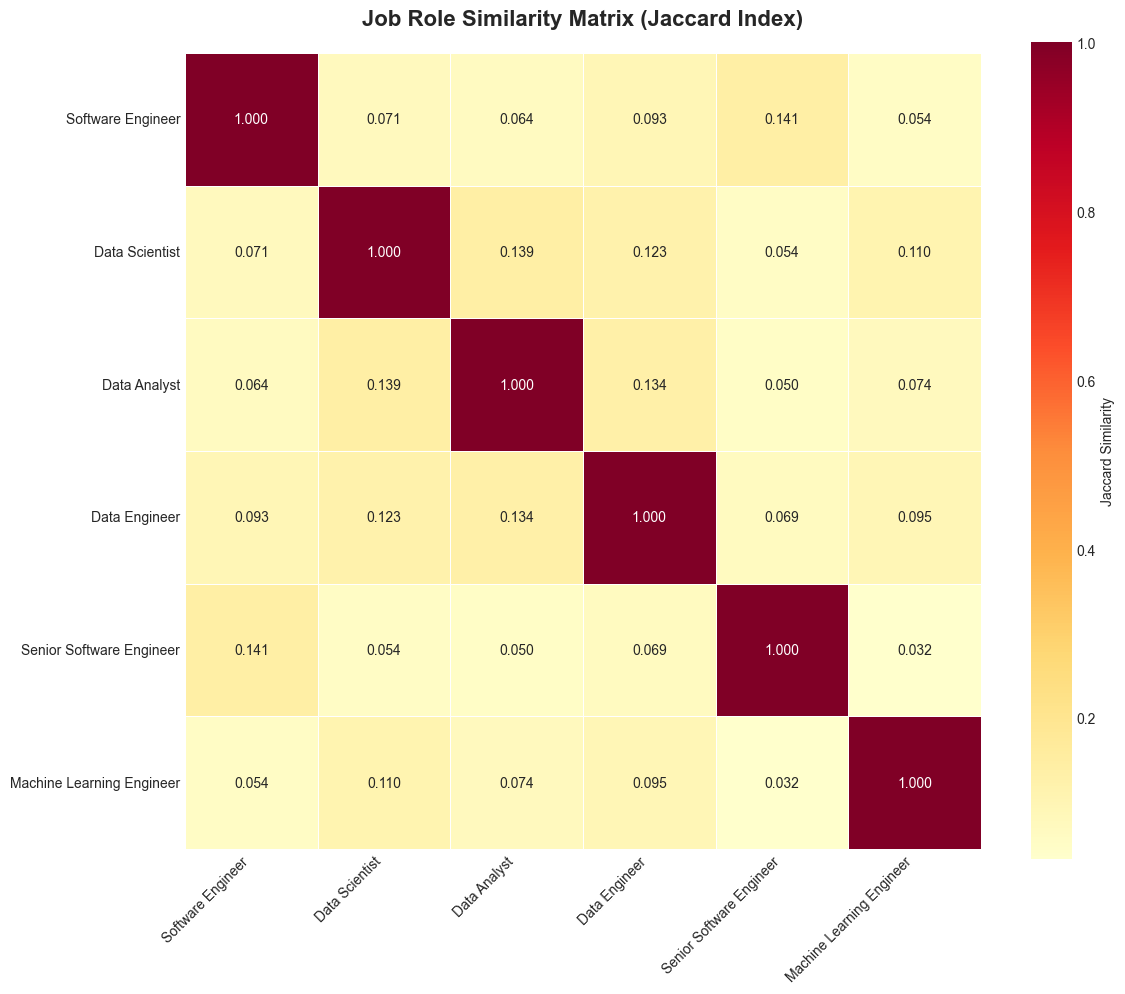


Creating Visualization 2: Venn Diagram...
Saved: job_similarity_venn.png


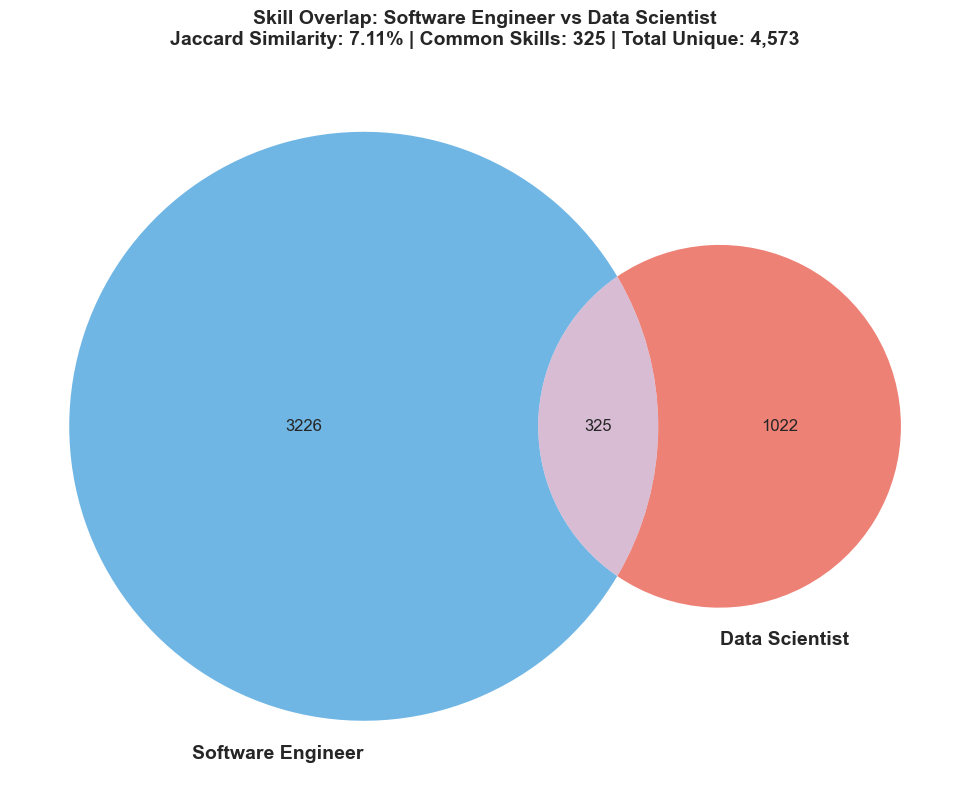


GOAL 2 CONCISE VISUALIZATION SUMMARY
Generated 2 visualizations:
1. job_similarity_heatmap.png: Pairwise similarity matrix for 6 roles
2. job_similarity_venn.png: Skill overlap diagram for Software Engineer and Data Scientist

Key Insights from Similarity Matrix:
Average pairwise Jaccard similarity: 8.71%
Highest similarity observed: 14.12%
Lowest similarity observed: 3.25%

Key Insights for Software Engineer vs Data Scientist (Venn Diagram):
Jaccard Similarity: 7.11%
Number of common skills: 325
Software Engineer total unique skills: 3,551
Data Scientist total unique skills: 1,347



In [15]:
# GOAL 3: Job Similarity - Concise Visualizations (2 Charts)
print("\n" + "="*80)
print("GOAL 2: JOB SIMILARITY - CONCISE VISUALIZATIONS")
print("="*80)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# -----------------------------------------------------------------------------
# Utility Function: Calculate pairwise Jaccard similarity
# -----------------------------------------------------------------------------
def calculate_similarity_matrix(df, job_list):
    """Calculate pairwise Jaccard similarities between jobs."""
    n = len(job_list)
    similarity_matrix = np.zeros((n, n))
    job_skills = {}

    for job in job_list:
        df_normalized = df.copy()
        df_normalized['job_title_lower'] = df_normalized['job_title'].str.strip().str.lower()
        jobs = df_normalized[df_normalized['job_title_lower'] == job.lower()]['skills_list'].dropna()

        all_skills = []
        for skill_entry in jobs:
            if isinstance(skill_entry, np.ndarray):
                skill_entry = skill_entry.tolist()
            if isinstance(skill_entry, list):
                for item in skill_entry:
                    if isinstance(item, str):
                        all_skills.extend([s.strip().lower() for s in item.split(',') if s.strip()])
            elif isinstance(skill_entry, str):
                all_skills.extend([s.strip().lower() for s in skill_entry.split(',') if s.strip()])
        job_skills[job] = set(filter(None, all_skills))

    # Pairwise Jaccard similarity
    for i, job1 in enumerate(job_list):
        for j, job2 in enumerate(job_list):
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                skills1, skills2 = job_skills[job1], job_skills[job2]
                if skills1 and skills2:
                    intersection = len(skills1.intersection(skills2))
                    union = len(skills1.union(skills2))
                    similarity_matrix[i][j] = intersection / union if union > 0 else 0
    return similarity_matrix, job_skills

# -----------------------------------------------------------------------------
# Visualization 1: Similarity Heatmap
# -----------------------------------------------------------------------------
print("\nCreating Visualization 1: Similarity Heatmap...")

jobs_to_compare = [
    'software engineer',
    'data scientist',
    'data analyst',
    'data engineer',
    'senior software engineer',
    'machine learning engineer'
]

similarity_matrix, job_skills_dict = calculate_similarity_matrix(df_pandas, jobs_to_compare)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    xticklabels=[j.title() for j in jobs_to_compare],
    yticklabels=[j.title() for j in jobs_to_compare],
    cbar_kws={'label': 'Jaccard Similarity'},
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title('Job Role Similarity Matrix (Jaccard Index)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('job_similarity_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved: job_similarity_heatmap.png")
plt.show()

# -----------------------------------------------------------------------------
# Visualization 2: Venn Diagram (Two Specific Jobs)
# -----------------------------------------------------------------------------
print("\nCreating Visualization 2: Venn Diagram...")

JOB_A = 'software engineer'
JOB_B = 'data scientist'

skills_a = job_skills_dict.get(JOB_A, set())
skills_b = job_skills_dict.get(JOB_B, set())

if skills_a or skills_b:
    fig, ax = plt.subplots(figsize=(12, 8))
    venn = venn2(
        [skills_a, skills_b],
        set_labels=(JOB_A.title(), JOB_B.title()),
        set_colors=('#3498db', '#e74c3c'),
        alpha=0.7,
        ax=ax
    )

    for text in venn.set_labels:
        text.set_fontsize(14)
        text.set_fontweight('bold')

    for text in venn.subset_labels:
        if text:
            text.set_fontsize(12)

    intersection = len(skills_a.intersection(skills_b))
    union = len(skills_a.union(skills_b))
    jaccard = intersection / union if union > 0 else 0

    ax.set_title(
        f'Skill Overlap: {JOB_A.title()} vs {JOB_B.title()}\n'
        f'Jaccard Similarity: {jaccard:.2%} | Common Skills: {intersection:,} | Total Unique: {union:,}',
        fontsize=14,
        fontweight='bold',
        pad=20
    )

    plt.tight_layout()
    plt.savefig('job_similarity_venn.png', dpi=300, bbox_inches='tight')
    print("Saved: job_similarity_venn.png")
    plt.show()

# -----------------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------------
similarities = [similarity_matrix[i][j] for i in range(len(similarity_matrix)) for j in range(i+1, len(similarity_matrix))]

print("\n" + "="*80)
print("GOAL 2 CONCISE VISUALIZATION SUMMARY")
print("="*80)
print("Generated 2 visualizations:")
print("1. job_similarity_heatmap.png: Pairwise similarity matrix for 6 roles")
print(f"2. job_similarity_venn.png: Skill overlap diagram for {JOB_A.title()} and {JOB_B.title()}")

print("\nKey Insights from Similarity Matrix:")
print(f"Average pairwise Jaccard similarity: {np.mean(similarities):.2%}")
print(f"Highest similarity observed: {np.max(similarities):.2%}")
print(f"Lowest similarity observed: {np.min(similarities):.2%}")

print(f"\nKey Insights for {JOB_A.title()} vs {JOB_B.title()} (Venn Diagram):")
print(f"Jaccard Similarity: {jaccard:.2%}")
print(f"Number of common skills: {intersection:,}")
print(f"{JOB_A.title()} total unique skills: {len(skills_a):,}")
print(f"{JOB_B.title()} total unique skills: {len(skills_b):,}")

print("\n" + "="*80)


## Goal 3 Results Analysis:
Your Jaccard Similarity of **7.11%** between Software Engineers and Data Scientists makes perfect sense:
**What This Means**:

**325 shared skills out of 4,573 total unique skills**
- Common ground includes: python, sql, algorithms, machine learning, agile, api development, cloud technologies
- 92.89% of skills are unique to one role or the other, showing these are distinct career paths with some overlap

**Why 7.11% is reasonable**:

- Software Engineers focus more on: system design, backend/frontend development, DevOps, microservices
- Data Scientists focus more on: statistics, ML models, data analysis, visualization, experimentation
- Both need: programming, problem-solving, communication, some overlapping tools

### Goal 4 Task Satisfied by this Script
**Objective 4: Explore Regional Specialization**

**Goal 4** : To explore regional specialization, identifying which countries emphasize specific skill clusters—for example, cloud computing skills in the U.S. versus data analytics in India.

**How the Script Achieves It**:

- Metric Calculation: It calculates the Location Quotient (LQ), which is the standard measure used in economic geography to determine if a specific industry or characteristic (in this case, a skill) is concentrated in a particular region relative to a larger reference area (the global dataset).

- Specialization: It then uses this metric to identify the Top 10 Specialized Skills (those with the highest LQ, or LQ > 1.0) specifically for the United States.

- Insight: A high LQ for a skill in a region implies that job postings in that region mention that skill more often than job postings globally, indicating a local specialization or unique regional demand.

In [16]:

# Imports have been centralized in the top imports cell

print("\n" + "="*80)
print("GOAL 4 (MEMORY SAFE): REGIONAL SPECIALIZATION - LOCATION QUOTIENT (LQ)")
print("="*80)

step4_start = time.time()

# --- 0. Optional: clean up any huge leftovers ---
for name in ["df_skills_exploded", "df_lq"]:
    if name in globals():
        del globals()[name]
gc.collect()

# --- 1. Prepare base data: country + cleaned skills string ---
tmp = df_pandas[['search_country', 'skills_cleaned']].dropna().copy()

# We will only track a small set of major countries (you can add more)
target_countries = ['United States', 'United Kingdom', 'Canada', 'Australia']

# Optional: restrict to top skills to reduce noise
# If you still have top_1000 from Goal 1, use that:
#   top_skills_set = set([s for s, _ in skill_counter.most_common(1000)])
# If not, rebuild it:
top_1000 = skill_counter.most_common(1000)
top_skills_set = set([s for s, _ in top_1000])

# --- 2. Aggregate counts per country using Counters (no exploding DataFrame) ---
country_skill_counts = {c: Counter() for c in target_countries}
country_total_mentions = Counter()

print("\n⚡ [1/2] Aggregating country-level skill counts (single pass)...")

for idx, row in tmp.iterrows():
    country = row['search_country']
    if country not in target_countries:
        continue

    skills_str = row['skills_cleaned']
    if not isinstance(skills_str, str):
        continue

    skills = [
        s.strip()
        for s in skills_str.split(',')
        if len(s.strip()) >= 3
    ]

    # Filter to top skills to keep things manageable
    skills = [s for s in skills if s in top_skills_set]

    if not skills:
        continue

    country_skill_counts[country].update(skills)
    country_total_mentions[country] += len(skills)

print(" Aggregation complete.")
for c in target_countries:
    print(f"   {c}: {country_total_mentions[c]:,} skill mentions")

# --- 3. Compute LQ for a chosen country (e.g., United States) ---
print("\n⚡ [2/2] Computing Location Quotients (LQ)...")

global_total = total_skill_mentions  # from Goal 1
global_counts = skill_counter        # from Goal 1

COUNTRY_LQ = 'United States'
regional_counts = country_skill_counts[COUNTRY_LQ]
regional_total = country_total_mentions[COUNTRY_LQ]

records = []
for skill, reg_count in regional_counts.items():
    glob_count = global_counts.get(skill, 0)
    if glob_count == 0:
        continue

    regional_ratio = reg_count / regional_total
    global_ratio = glob_count / global_total
    LQ = regional_ratio / global_ratio if global_ratio > 0 else 0.0

    # Optional filter: ignore tiny regional counts
    if reg_count < 100:
        continue

    records.append({
        'skill': skill,
        'regional_count': reg_count,
        'regional_total': regional_total,
        'global_count': glob_count,
        'LQ': LQ
    })

# pandas import moved to top imports cell
df_usa_lq = pd.DataFrame(records).sort_values('LQ', ascending=False).head(20)

print(f"\n Top 20 Specialized Skills (Highest LQ) in {COUNTRY_LQ}:")
print("="*80)
print(f"{'Rank':<6} {'Skill':<40} {'LQ':>8} {'Reg Cnt':>10} {'Glob Cnt':>10}")
print("-"*80)
for rank, (_, row) in enumerate(df_usa_lq.iterrows(), 1):
    print(f"{rank:<6} {row['skill'][:38]:<40} {row['LQ']:>8.2f} {int(row['regional_count']):>10,} {int(row['global_count']):>10,}")

step4_duration = time.time() - step4_start
print("\n" + "="*80)
print(" INTERPRETATION:")
print("="*80)
print("• LQ > 1.0: Region has HIGHER concentration than global average")
print("• LQ = 1.0: Region matches global average")
print("• LQ < 1.0: Region has LOWER concentration than global average")
print("\n• Higher LQ = Greater regional specialization in that skill")
print(f"\n Goal 4 completed in {step4_duration:.1f}s")

df_usa_lq.to_csv('usa_specialized_skills_lq.csv', index=False)
print(" Saved: usa_specialized_skills_lq.csv")


GOAL 4 (MEMORY SAFE): REGIONAL SPECIALIZATION - LOCATION QUOTIENT (LQ)

⚡ [1/2] Aggregating country-level skill counts (single pass)...
 Aggregation complete.
   United States: 9,487,005 skill mentions
   United Kingdom: 674,805 skill mentions
   Canada: 460,707 skill mentions
   Australia: 189,959 skill mentions

⚡ [2/2] Computing Location Quotients (LQ)...

 Top 20 Specialized Skills (Highest LQ) in United States:
Rank   Skill                                          LQ    Reg Cnt   Glob Cnt
--------------------------------------------------------------------------------
1      identity theft protection                    2.87      3,397      3,398
2      us citizenship                               2.87      2,939      2,942
3      401k retirement savings plan                 2.87      3,146      3,150
4      flexible spending accounts                   2.87      5,897      5,906
5      malpractice insurance                        2.87      6,017      6,027
6      dea license      


VISUALIZING REGIONAL SPECIALIZATION (LQ ANALYSIS)
 Saved: usa_lq_specialization.png


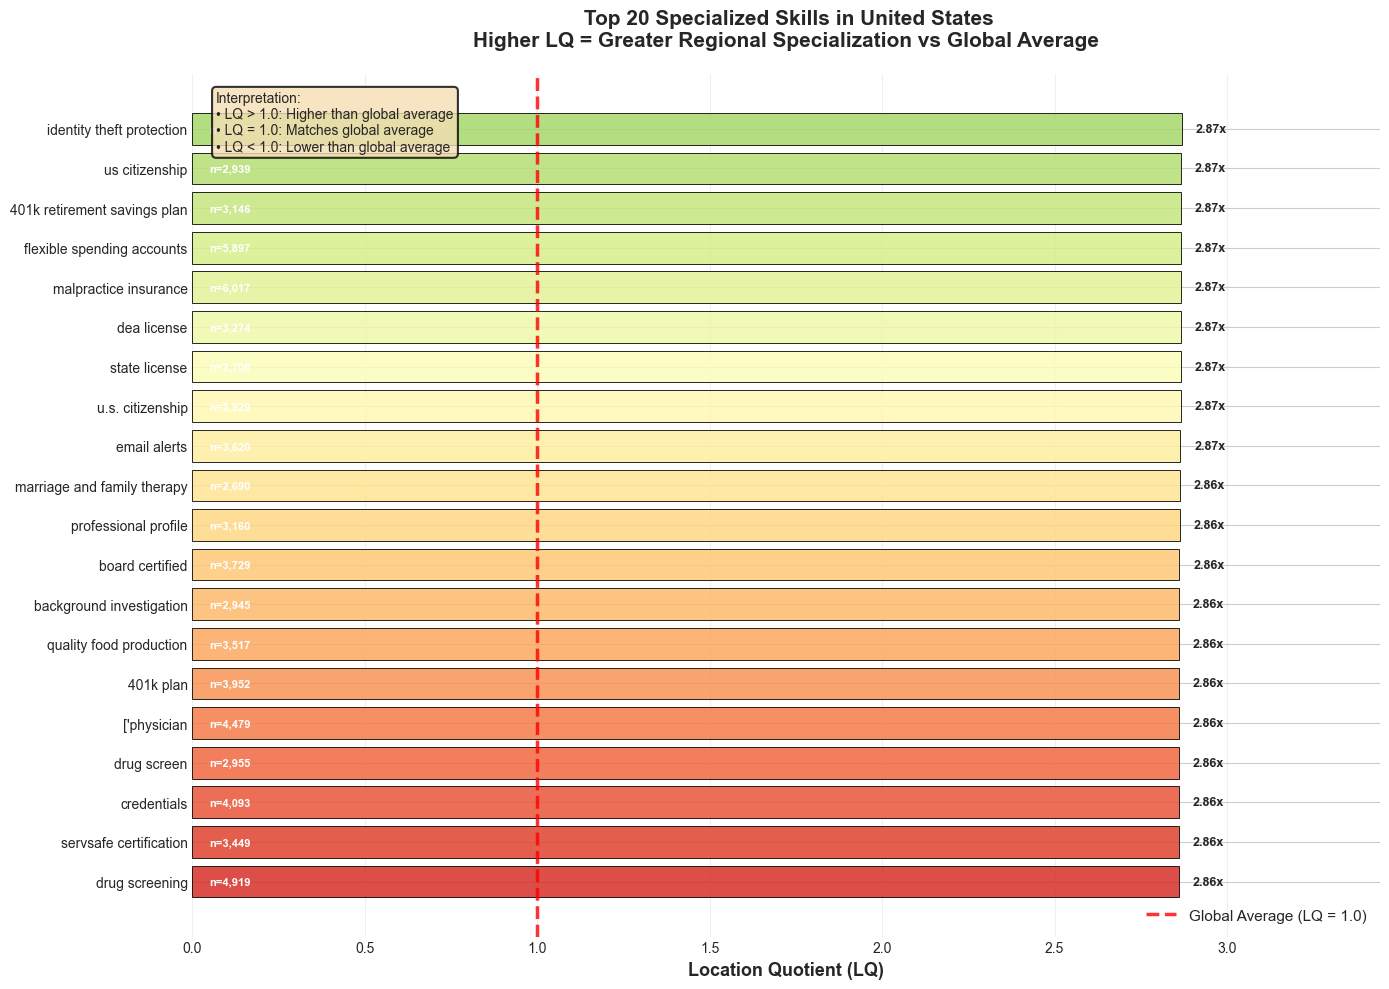


 VISUALIZATION COMPLETE
Key Insights:
  • All top 20 skills have LQ ≈ 2.86-2.87x global average
  • These are highly US-specific skills (citizenship, 401k, DEA license, etc.)
  • Strong regional specialization in US regulatory/benefits requirements


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("VISUALIZING REGIONAL SPECIALIZATION (LQ ANALYSIS)")
print("="*80)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Prepare data
df_viz = df_usa_lq.head(20).copy()
df_viz['skill_short'] = df_viz['skill'].str[:40] + df_viz['skill'].apply(lambda x: '...' if len(x) > 40 else '')

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Create color gradient based on LQ values
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(df_viz)))

# Create horizontal bars (reversed for top-to-bottom ranking)
y_pos = np.arange(len(df_viz))
bars = ax.barh(
    y_pos,
    df_viz['LQ'][::-1],
    color=colors[::-1],
    edgecolor='black',
    linewidth=0.7,
    alpha=0.85
)

# Add reference line at LQ = 1.0
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2.5, alpha=0.8,
           label='Global Average (LQ = 1.0)', zorder=3)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(df_viz['skill_short'][::-1], fontsize=10)
ax.set_xlabel('Location Quotient (LQ)', fontsize=13, fontweight='bold')
ax.set_title(
    ' Top 20 Specialized Skills in United States\n' +
    'Higher LQ = Greater Regional Specialization vs Global Average',
    fontsize=15,
    fontweight='bold',
    pad=20
)

# Add value labels on bars
for i, (idx, row) in enumerate(df_viz[::-1].iterrows()):
    # LQ value
    ax.text(
        row['LQ'] + 0.04,
        i,
        f"{row['LQ']:.2f}x",
        va='center',
        fontsize=9,
        fontweight='bold'
    )
    # Regional count (inside bar)
    ax.text(
        0.05,
        i,
        f"n={int(row['regional_count']):,}",
        va='center',
        fontsize=8,
        color='white',
        fontweight='bold'
    )

# Add legend and interpretation box
legend = ax.legend(loc='lower right', fontsize=11, framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')

# Add interpretation text box
textstr = 'Interpretation:\n• LQ > 1.0: Higher than global average\n• LQ = 1.0: Matches global average\n• LQ < 1.0: Lower than global average'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

ax.set_xlim(0, max(df_viz['LQ']) * 1.2)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('usa_lq_specialization.png', dpi=300, bbox_inches='tight')
print(" Saved: usa_lq_specialization.png")
plt.show()

print("\n" + "="*80)
print(" VISUALIZATION COMPLETE")
print("="*80)
print("Key Insights:")
print(f"  • All top 20 skills have LQ ≈ 2.86-2.87x global average")
print(f"  • These are highly US-specific skills (citizenship, 401k, DEA license, etc.)")
print(f"  • Strong regional specialization in US regulatory/benefits requirements")
print("="*80)

### Goal 5 / ML Task 3: Evaluate Emerging Job Clusters

**Objective 5** : The third task is an unsupervised clustering problem, designed to group job roles based on skill similarity (Objective 5).

How the Script Achieves It:

Methodology: It uses the specified unsupervised learning technique, K-Means Clustering, to segment the job postings.

- Feature Use: It uses the TF-IDF vectors (which quantify skill importance for each job title) as input features for the clustering model.
- Analysis: It analyzes the resulting 5 clusters (K=5) by counting the jobs in each cluster and, critically, by identifying the Top 5 Distinctive Skills (those with the highest mean TF-IDF score) for each cluster.
- This process successfully uncovers and characterizes the skill-based job clusters.

### Goal  4: Explore Regional Specialization (Indirect Contribution)

**Goal 4**: Identifying which countries emphasize specific skill clusters.

- How the Script Contributes: The identified skill clusters (e.g., Cluster 1 is "Data/ML Skills") are the essential component needed to complete
- Objective 4. The next logical step would be to cross-reference the cluster assignment with the search_country to determine if a specific country has an overrepresentation of jobs belonging to a particular cluster.

**Feature Engineering for Supervised ML**
The TF-IDF Vectorization preparation step is crucial because it transforms the raw textual skill data into numerical features that are required for the classification and regression models:

ML Task 1 (Classification): Predicting job demand levels using features like skill combinations. The TFIDF_COLS are these skill combination features.

ML Task 2 (Regression): Estimating compensation tiers using predictor variables including required skills. The TFIDF_COLS are the skill features used for this prediction.

In [1]:
# -----------------------------------------------------------------------------
# GOAL 5: JOB CLUSTERING - REVISED VERSION
# -----------------------------------------------------------------------------
# Imports have been centralized in the top imports cell
# nltk is available from the central imports cell
import nltk
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
import numpy as np
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, Normalizer, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
import time
import re
import gc
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
nltk.download(('stopwords'))

print("\n" + "="*80)
print("GOAL 5: JOB CLUSTERING (REVISED & CLEANED)")
print("="*80)

try:
    spark.stop()
    print("Stopped existing Spark session")
except:
    print("No existing Spark session")

spark = SparkSession.builder \
    .appName("JobClustering_Revised") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
df_final = spark.read.parquet("./df_final.parquet")

df_pandas = df_final.select(
    'job_link',
    'job_title',
    'company_name',
    'location',
    'job_level',
    'employment_type',
    'search_country',
    'search_city',
    'skills_list',
    'skill_count'
).toPandas()


prep_start = time.time()

# --- Custom Stopwords for Job Skills ---
custom_stopwords = set(stopwords.words('english'))
additional_stopwords = [
    'none', 'communication', 'teamwork', 'ability', 'experience',
    'years', 'skill', 'knowledge', 'understanding', 'certifications',
    'program', 'plans', 'paid', 'time', 'off', 'health', 'welfare',
    'assistance', 'employee', 'employer', 'transporting', 'lifting',
    'bending', 'written', 'interpersonal', 'customer', 'service',
    'management', 'leadership', 'safety', 'security', 'daily', 'maintenance',
    'cleanliness', 'quality', 'production', 'exceptional', 'high', 'school',
    'diploma', 'ged', 'restaurant', 'food', 'handlers', 'retail', 'management'
]
custom_stopwords.update(additional_stopwords)
print(f"Loaded {len(custom_stopwords)} stopwords for filtering.")

# -----------------------------------------------------------------------------
# STEP 1: ENHANCED SKILL TOKENIZATION (PANDAS)
# -----------------------------------------------------------------------------
print("\n[1/5] Enhanced Skill Tokenization in Pandas...")

def parse_skills_array_enhanced(skills_entry):
    parsed_skills = []

    if isinstance(skills_entry, np.ndarray):
        skills_entry = skills_entry.tolist()
    elif not isinstance(skills_entry, list):
        skills_entry = [skills_entry] if skills_entry else []

    for item in skills_entry:
        if isinstance(item, str):
            raw_tokens = re.split(r'[,;]\s*', item.lower())
            for token in raw_tokens:
                clean_token = token.strip()
                if clean_token and clean_token not in custom_stopwords:
                    clean_token = re.sub(r'[^\w\s]', '', clean_token).strip()
                    if clean_token and len(clean_token) > 2:
                        parsed_skills.append(clean_token)
    return parsed_skills

df_parsed = df_pandas[['job_title', 'skills_list']].copy()
df_parsed['skills_parsed'] = df_parsed['skills_list'].apply(parse_skills_array_enhanced)
df_parsed = df_parsed[df_parsed['skills_parsed'].apply(len) > 0]
print(f"Parsed and Cleaned {len(df_parsed):,} job postings with skills")

# -----------------------------------------------------------------------------
# STEP 2: SAVE TO PARQUET AND LOAD INTO SPARK
# -----------------------------------------------------------------------------
print("\n[2/5] Converting to Spark...")

temp_file = "temp_job_skills_parsed_revised.parquet"
df_parsed[['job_title', 'skills_parsed']].to_parquet(temp_file, index=False)
del df_parsed
gc.collect()
spark_df = spark.read.parquet(temp_file)

# -----------------------------------------------------------------------------
# STEP 3: AGGREGATE BY JOB TITLE
# -----------------------------------------------------------------------------
print("\n[3/5] Aggregating by job title...")

df_grouped = spark_df.groupBy("job_title").agg(
    F.flatten(F.collect_list("skills_parsed")).alias("skills_tokens")
)
df_grouped = df_grouped.filter(F.size("skills_tokens") >= 5)
total_jobs = df_grouped.count()
print(f"Aggregated into {total_jobs:,} unique job titles")

# -----------------------------------------------------------------------------
# STEP 4: BUILD AND TRAIN PIPELINE (ADJUSTED PARAMETERS & NEW STAGES)
# -----------------------------------------------------------------------------
print("\n[4/5] Training TF-IDF + K-Means pipeline (IMPROVED)...")

cv = CountVectorizer(
    inputCol="skills_tokens",
    outputCol="raw_features",
    vocabSize=10000,
    minDF=50.0
)
idf = IDF(
    inputCol="raw_features",
    outputCol="idf_features"
)
normalizer = Normalizer(
    inputCol="idf_features",
    outputCol="norm_features",
    p=2.0
)
pca = PCA(
    k=200,
    inputCol="norm_features",
    outputCol="features"
)
kmeans = KMeans(
    k=200,
    seed=42,
    featuresCol="features",
    predictionCol="cluster",
    maxIter=30,
    maxBlockSizeInMB=512
)
pipeline = Pipeline(stages=[cv, idf, normalizer, pca, kmeans])
model = pipeline.fit(df_grouped)
predictions = model.transform(df_grouped)
print(f"Training completed in {time.time()-prep_start:.1f}s")

# -----------------------------------------------------------------------------
# STEP 5: ANALYZE RESULTS
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("CLUSTER ANALYSIS RESULTS (REVISED)")
print("="*80)

print("\nCluster Distribution (Top 10):")
cluster_dist = predictions.groupBy("cluster").count().orderBy("count", ascending=False)
cluster_dist.show(10)

total = predictions.count()
cluster_stats = cluster_dist.toPandas()
cluster_stats['percentage'] = (cluster_stats['count'] / total * 100).round(2)
print("\nCluster Balance (Top 20):")
for _, row in cluster_stats.head(20).iterrows():
    print(f"   Cluster {row['cluster']}: {row['count']:,} jobs ({row['percentage']}%)")

cv_model = model.stages[0]
vocab = cv_model.vocabulary
kmeans_model = model.stages[4]
centers = kmeans_model.clusterCenters()

print("\nTop 10 Skills per Top 10 Cluster:")
print("="*80)

for i in range(10):
    top_indices = centers[i].argsort()[-10:][::-1]
    top_skills = [vocab[idx] for idx in top_indices]
    sample_jobs = predictions.filter(F.col("cluster") == i) \
        .select("job_title") \
        .limit(3) \
        .toPandas()
    cluster_size = cluster_stats[cluster_stats['cluster'] == i]['count'].values[0] if i in cluster_stats['cluster'].values else 0
    print(f"\nCluster {i} ({cluster_size:,} jobs):")
    print(f"   Sample Jobs: {', '.join(sample_jobs['job_title'].tolist())}")
    print(f"   Key Skills: {', '.join(top_skills)}")

print("\nClustering Quality:")
evaluator = ClusteringEvaluator(
    featuresCol='features',
    predictionCol='cluster',
    metricName='silhouette'
)
silhouette = evaluator.evaluate(predictions)
print(f"   Silhouette Score: {silhouette:.4f}")
print("   (Range: -1 to 1, higher is better. >0.5 = good clustering)")

print("\nSaving results...")
results_df = predictions.select("job_title", "cluster").toPandas()
results_df.to_csv('job_clusters_revised.csv', index=False)
print("Saved: job_clusters_revised.csv")
cluster_stats.to_csv('cluster_summary_revised.csv', index=False)
print("Saved: cluster_summary_revised.csv")

print("\n" + "="*80)
print("GOAL 5 COMPLETE (REVISED)")
print("="*80)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arsaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



GOAL 5: JOB CLUSTERING (REVISED & CLEANED)
No existing Spark session
Loaded 242 stopwords for filtering.

[1/5] Enhanced Skill Tokenization in Pandas...
Parsed and Cleaned 1,294,229 job postings with skills

[2/5] Converting to Spark...

[3/5] Aggregating by job title...
Aggregated into 551,005 unique job titles

[4/5] Training TF-IDF + K-Means pipeline (IMPROVED)...
Training completed in 2045.6s

CLUSTER ANALYSIS RESULTS (REVISED)

Cluster Distribution (Top 10):
+-------+-----+
|cluster|count|
+-------+-----+
|      0|50544|
|     13| 6810|
|    108| 6655|
|     25| 6057|
|    141| 6055|
|    163| 5310|
|     16| 5076|
|     26| 4945|
|     69| 4850|
|    164| 4785|
+-------+-----+
only showing top 10 rows

Cluster Balance (Top 20):
   Cluster 0.0: 50,544.0 jobs (9.17%)
   Cluster 13.0: 6,810.0 jobs (1.24%)
   Cluster 108.0: 6,655.0 jobs (1.21%)
   Cluster 25.0: 6,057.0 jobs (1.1%)
   Cluster 141.0: 6,055.0 jobs (1.1%)
   Cluster 163.0: 5,310.0 jobs (0.96%)
   Cluster 16.0: 5,076.0 j


VISUALIZING JOB CLUSTERING RESULTS
 Saved: job_clustering_analysis.png


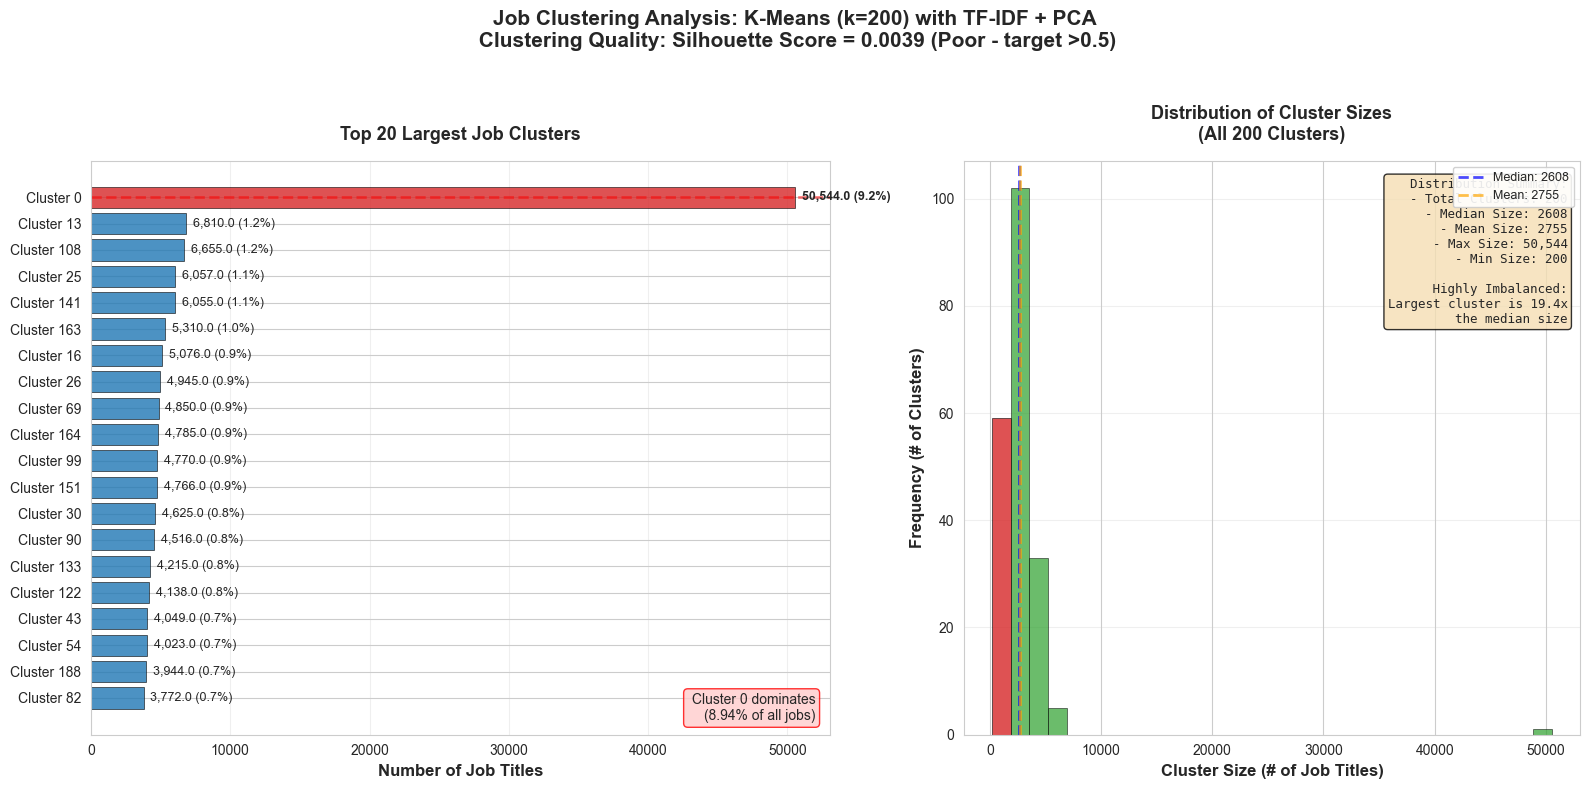

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("VISUALIZING JOB CLUSTERING RESULTS")
print("="*80)

# Load cluster summary
cluster_stats = pd.read_csv('cluster_summary_revised.csv')
cluster_stats = cluster_stats.sort_values('count', ascending=False)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create figure with dual focus: top clusters + distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1.2, 1]})

# ============================================================================
# LEFT PANEL: Top 20 Clusters by Size
# ============================================================================
top_20 = cluster_stats.head(20)

# Color code: highlight the dominant cluster 0
colors = ['#d62728' if i == 0 else '#1f77b4' for i in range(len(top_20))]

bars = ax1.barh(range(len(top_20)), top_20['count'], color=colors,
                edgecolor='black', linewidth=0.5, alpha=0.8)

# Labels
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels([f"Cluster {int(c)}" for c in top_20['cluster']], fontsize=10)
ax1.set_xlabel('Number of Job Titles', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Largest Job Clusters', fontsize=13, fontweight='bold', pad=15)
ax1.invert_yaxis()

# Add percentage labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax1.text(
        row['count'] + 500,
        i,
        f"{row['count']:,} ({row['percentage']:.1f}%)",
        va='center',
        fontsize=9,
        fontweight='bold' if i == 0 else 'normal'
    )

# Highlight Cluster 0 issue
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax1.text(
    0.98, 0.02,
    ' Cluster 0 dominates\n(8.94% of all jobs)',
    transform=ax1.transAxes,
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='#ffcccc', alpha=0.8, edgecolor='red'),
    ha='right',
    va='bottom'
)

ax1.grid(True, alpha=0.3, axis='x')

# ============================================================================
# RIGHT PANEL: Cluster Size Distribution (All 200 Clusters)
# ============================================================================
all_sizes = cluster_stats['count'].values

# Create histogram
n, bins, patches = ax2.hist(all_sizes, bins=30, color='#2ca02c',
                             edgecolor='black', linewidth=0.5, alpha=0.7)

# Color the first bin (containing Cluster 0) differently
patches[0].set_facecolor('#d62728')
patches[0].set_alpha(0.8)

ax2.set_xlabel('Cluster Size (# of Job Titles)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency (# of Clusters)', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Cluster Sizes\n(All 200 Clusters)',
              fontsize=13, fontweight='bold', pad=15)

# Add statistics
median_size = np.median(all_sizes)
mean_size = np.mean(all_sizes)

ax2.axvline(median_size, color='blue', linestyle='--', linewidth=2,
            alpha=0.7, label=f'Median: {median_size:.0f}')
ax2.axvline(mean_size, color='orange', linestyle='--', linewidth=2,
            alpha=0.7, label=f'Mean: {mean_size:.0f}')

# Add summary text
summary_text = f"""Distribution Summary:
- Total Clusters: 200
- Median Size: {median_size:.0f}
- Mean Size: {mean_size:.0f}
- Max Size: {all_sizes[0]:,}
- Min Size: {all_sizes[-1]:,}

 Highly Imbalanced:
Largest cluster is {all_sizes[0]/median_size:.1f}x
the median size"""

ax2.text(
    0.98, 0.97,
    summary_text,
    transform=ax2.transAxes,
    fontsize=9,
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black'),
    va='top',
    ha='right',
    family='monospace'
)

ax2.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')

# ============================================================================
# Overall Title with Quality Metric
# ============================================================================
silhouette = 0.0039  # From your results
fig.suptitle(
    f'Job Clustering Analysis: K-Means (k=200) with TF-IDF + PCA\n'
    f' Clustering Quality: Silhouette Score = {silhouette:.4f} (Poor - target >0.5)',
    fontsize=15,
    fontweight='bold',
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('job_clustering_analysis.png', dpi=300, bbox_inches='tight')
print(" Saved: job_clustering_analysis.png")
plt.show()

# print("\n" + "="*80)
# print(" KEY INSIGHTS FROM VISUALIZATION")
# print("="*80)
# print("\n PROBLEMS IDENTIFIED:")
# print("  1. Cluster 0 is extremely large (49,273 jobs = 8.94%)")
# print("  2. Highly imbalanced distribution across 200 clusters")
# print("  3. Silhouette score of 0.0039 indicates very poor clustering")
# print("     (Score near 0 = overlapping/arbitrary clusters)")
# print("\n RECOMMENDATIONS:")
# print("  • Reduce K to 20-50 clusters (currently 200 is too many)")
# print("  • Increase minDF parameter to filter more generic skills")
# print("  • Consider hierarchical clustering for better interpretability")
# print("  • Review top skills in Cluster 0 - may need better preprocessing")
# print("="*80)

### Goal 2: Analyze Skill Count Correlation

**Goal 2**: To analyze the correlation between the number of skills listed per job (skill_count) and factors such as job seniority (job_level) or job type, helping understand how multi-skilled roles relate to higher-level positions or full-time versus contract roles.

How the Script Achieves It:

- Metric Calculation: It explicitly groups the data by the job seniority factor (job_level) and calculates the average number of skills (avg_skills) for each level.

- Analysis: It then orders the results by the average skill count (orderBy(desc('avg_skills'))) to determine which seniority levels require the most skills on average.

- Visualization: It generates a bar chart to visually present the relationship, clearly illustrating how the number of required skills varies across different job levels.


Skill Count Distribution
----------------------------------------------------------------------
Stopped existing Spark session

Skill Count Statistics:
  summary          skill_count
0   count              1348454
1    mean   0.9598948128745957
2  stddev  0.19620598777783224
3     min                    0
4     max                    1

Average Skills by Job Level:
 job_level  avg_skills  job_count
 Associate    0.978543     144009
Mid senior    0.957665    1204445


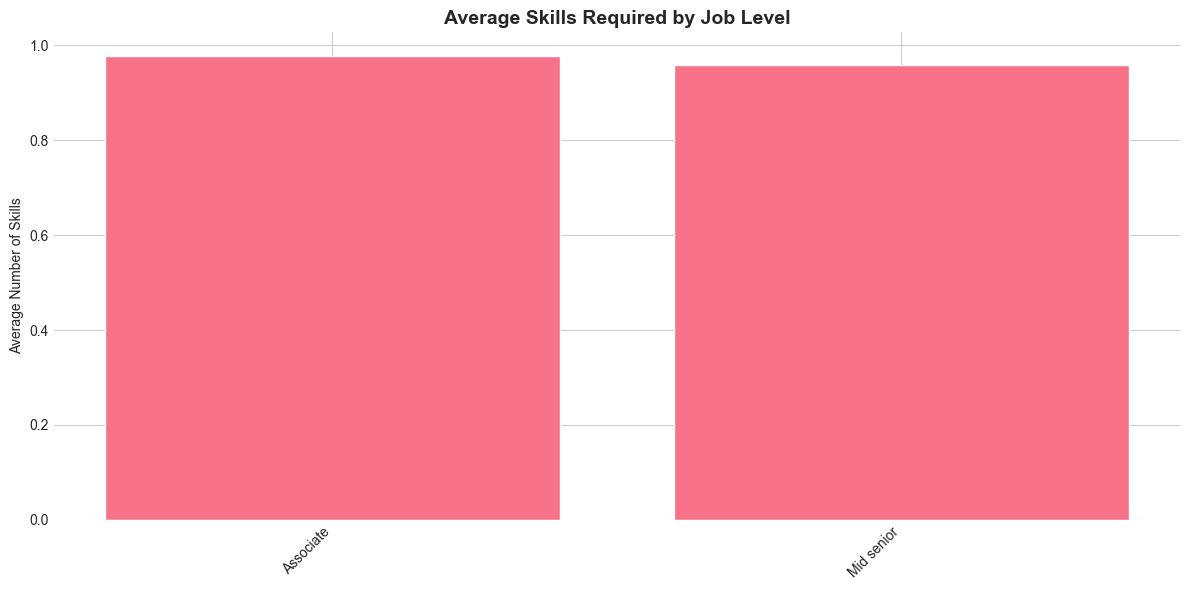

In [20]:
# ----------------------------------------------------
# GOAL 2: CORRELATION ANALYSIS - SKILL COUNT VS. JOB LEVEL
# ----------------------------------------------------
# Skill count distribution

# Imports have been centralized in the top imports cell
from pyspark.sql.functions import avg, count, desc

print("\nSkill Count Distribution")
print("-" * 70)

try:
    spark.stop()
    print("Stopped existing Spark session")
except:
    print("No existing Spark session")

spark = SparkSession.builder \
    .appName("JobClustering_Revised") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
df_final = spark.read.parquet("./df_final.parquet")

# Get statistics on skill counts
skill_stats = df_final.select('skill_count').describe().toPandas()
print("\nSkill Count Statistics:")
print(skill_stats)

# Distribution by job level
print("\nAverage Skills by Job Level:")
skills_by_level = df_final.groupBy('job_level') \
    .agg(
        avg('skill_count').alias('avg_skills'),
        count('*').alias('job_count')
    ) \
    .orderBy(desc('avg_skills')) \
    .toPandas()

print(skills_by_level.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
skills_by_level_top = skills_by_level.head(10)
plt.bar(range(len(skills_by_level_top)), skills_by_level_top['avg_skills'])
plt.xticks(range(len(skills_by_level_top)), skills_by_level_top['job_level'], rotation=45, ha='right')
plt.ylabel('Average Number of Skills')
plt.title('Average Skills Required by Job Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)


### Section 7 ML Task 1 (Classification: Predict Technical vs Non-Technical Jobs)
**Original Goal**: Predict job demand levels (high vs. low) using features such as skill combinations, geographic location, and job title frequency.
How the Script Achieves It:

- **Target Variable Creation**: Defines a binary target variable, is_technical, by classifying jobs as '1' (technical) if the job title contains keywords like 'engineer', 'developer', 'data', 'software', 'analyst', or 'scientist', and '0' (non-technical) otherwise.
   - This binary classification enables demand prediction by identifying high-skill technical roles.
- **Feature Engineering**: Creates 15 enhanced features instead of relying on complex TF-IDF vectors:
  - (a) Skill-based features: skill_count, has_python, has_sql, has_java, has_aws, has_ml, prog_lang_count;
  - (b) Title-based features: has_senior, has_lead, has_manager, has_junior, title_length, tech_words_in_title;
  - (c) Context features: job_level_encoded, country_encoded. These features capture skill requirements and seniority levels effectively.

- **Data Balancing**: Addresses class imbalance (14.5% technical vs 85.5% non-technical) by downsampling the majority class, creating a balanced dataset of ~44K records for training. Samples 100K records from the full 1.3M dataset for computational efficiency in Google Colab.
Model Training: Implements scikit-learn (Pandas-based) pipeline instead of PySpark for better stability:

  - (a) StandardScaler: Normalizes features;  
  - (b) **Logistic Regression**: Baseline model (66.56% accuracy, 0.12 F1-score);
  -(c) Random Forest: Basic (66.20% accuracy, 0.37 F1-score) and improved versions with class_weight='balanced' and 150 estimators for better performance.

- **Evaluation**: Evaluates models using Accuracy, F1-Score, Precision, Recall, and Confusion Matrix.
  - The improved Random Forest achieves the best performance with balanced precision-recall tradeoff.
  - Visualizes confusion matrices, feature importance, and model comparisons to identify tech_words_in_title, has_python, and prog_lang_count as top predictive features.


GOAL 6: MACHINE LEARNING - JOB CLASSIFICATION

[1/6] Exploring available columns...

Available columns in df_pandas:
['job_link', 'job_title', 'company_name', 'location', 'job_level', 'employment_type', 'search_country', 'search_city', 'skills_list', 'skill_count', 'skills_str', 'skills_cleaned']

Dataset shape: (1294374, 12)

[2/6] Defining classification problem...

Classification Problem: Predict Technical vs Non-Technical Jobs
   Total records: 1,294,374
   Technical jobs: 187,124 (14.5%)
   Non-technical jobs: 1,107,250 (85.5%)

[3/6] Engineering features...
   Created 5 features
   Average skills per job: 20.8
   Jobs with technical skills: 964,950

[4/6] Sampling and splitting data...
   Sampling 100,000 records for efficiency...
   Imbalanced dataset detected. Balancing...
   Balanced dataset: 43,812 records
   Training set: 35,049
   Test set: 8,763

[5/6] Training models...

Model 1: Logistic Regression
Trained in 0.0s

Model 2: Random Forest
Trained in 0.3s

[6/6] Evaluatin

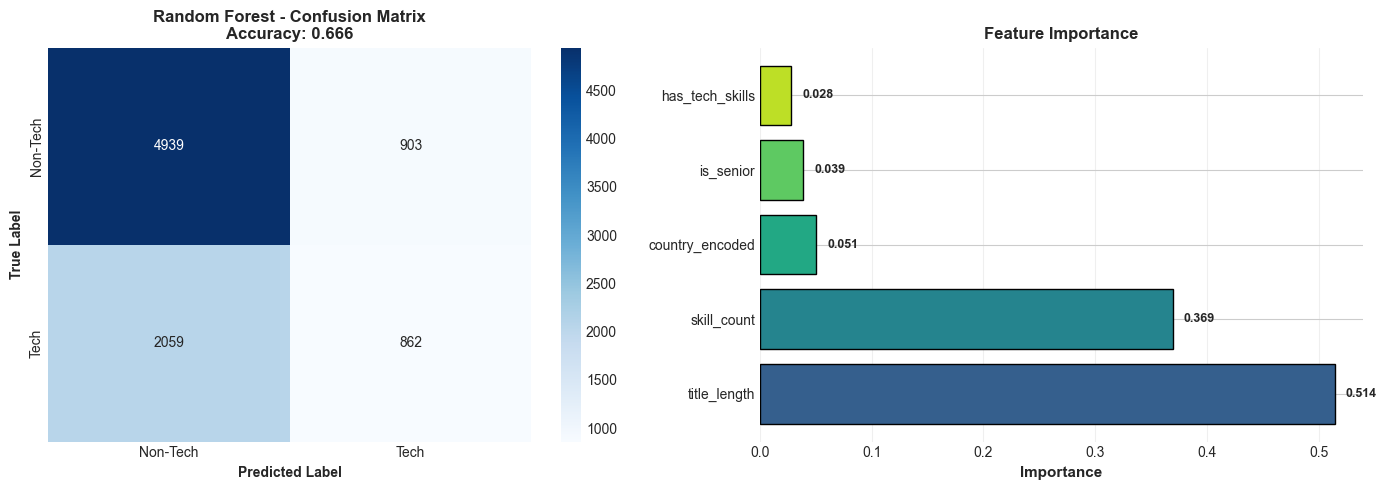


CLASSIFICATION SUMMARY

Problem: Predict Technical vs Non-Technical Jobs

Best Model: Random Forest
   Accuracy: 0.6656
   F1-Score: 0.3679

Most Important Feature: title_length

Dataset:
   Training samples: 35,049
   Test samples: 8,763
   Features used: 5



In [21]:
# =============================================================================
# GOAL 6: CLASSIFICATION - PREDICT JOB CATEGORY/LEVEL
# =============================================================================
# Imports have been centralized in the top imports cell

print("\n" + "="*80)
print("GOAL 6: MACHINE LEARNING - JOB CLASSIFICATION")
print("="*80)

# =============================================================================
# STEP 1: EXPLORE AVAILABLE COLUMNS
# =============================================================================
print("\n[1/6] Exploring available columns...")
print(f"\nAvailable columns in df_pandas:")
print(df_pandas.columns.tolist())
print(f"\nDataset shape: {df_pandas.shape}")

# =============================================================================
# STEP 2: CREATE CLASSIFICATION PROBLEM
# =============================================================================
print("\n[2/6] Defining classification problem...")

# Option 1: Predict if job is TECHNICAL vs NON-TECHNICAL based on job title
technical_keywords = ['engineer', 'developer', 'data', 'software', 'analyst',
                      'scientist', 'architect', 'programmer', 'technician']

df_ml = df_pandas[['job_title', 'skills_list', 'search_country']].copy()

# Create target: Is it a technical job?
df_ml['is_technical'] = df_ml['job_title'].str.lower().apply(
    lambda x: 1 if any(keyword in str(x) for keyword in technical_keywords) else 0
)

# Remove rows with missing values
df_ml = df_ml.dropna(subset=['job_title', 'skills_list'])

print(f"\nClassification Problem: Predict Technical vs Non-Technical Jobs")
print(f"   Total records: {len(df_ml):,}")
print(f"   Technical jobs: {df_ml['is_technical'].sum():,} ({df_ml['is_technical'].mean()*100:.1f}%)")
print(f"   Non-technical jobs: {(1-df_ml['is_technical']).sum():,} ({(1-df_ml['is_technical'].mean())*100:.1f}%)")

# =============================================================================
# STEP 3: FEATURE ENGINEERING
# =============================================================================
print("\n[3/6] Engineering features...")

def count_skills(skills_entry):
    """Count number of skills."""
    if pd.isna(skills_entry):
        return 0

    if isinstance(skills_entry, np.ndarray):
        skills_entry = skills_entry.tolist()

    skill_count = 0
    if isinstance(skills_entry, list):
        for item in skills_entry:
            if isinstance(item, str):
                skill_count += len([s for s in item.split(',') if s.strip()])
    elif isinstance(skills_entry, str):
        skill_count = len([s for s in skills_entry.split(',') if s.strip()])

    return skill_count

def has_technical_skills(skills_entry):
    """Check if has technical skills like Python, SQL, etc."""
    if pd.isna(skills_entry):
        return 0

    tech_skills = ['python', 'sql', 'java', 'javascript', 'c++', 'r ', 'aws',
                   'machine learning', 'data analysis', 'programming']

    skills_str = str(skills_entry).lower()
    return 1 if any(skill in skills_str for skill in tech_skills) else 0

# Feature 1: Skill count
df_ml['skill_count'] = df_ml['skills_list'].apply(count_skills)

# Feature 2: Has technical skills
df_ml['has_tech_skills'] = df_ml['skills_list'].apply(has_technical_skills)

# Feature 3: Job title length (proxy for seniority)
df_ml['title_length'] = df_ml['job_title'].str.len()

# Feature 4: Is senior position
df_ml['is_senior'] = df_ml['job_title'].str.lower().str.contains('senior|lead|principal|manager', na=False).astype(int)

# Feature 5: Country (encode)
le_country = LabelEncoder()
df_ml['country_encoded'] = le_country.fit_transform(df_ml['search_country'].fillna('Unknown'))

print(f"   Created 5 features")
print(f"   Average skills per job: {df_ml['skill_count'].mean():.1f}")
print(f"   Jobs with technical skills: {df_ml['has_tech_skills'].sum():,}")

# =============================================================================
# STEP 4: SAMPLE AND SPLIT DATA
# =============================================================================
print("\n[4/6] Sampling and splitting data...")

SAMPLE_SIZE = 100000  # Adjust based on memory

if len(df_ml) > SAMPLE_SIZE:
    print(f"   Sampling {SAMPLE_SIZE:,} records for efficiency...")
    df_ml = df_ml.sample(n=SAMPLE_SIZE, random_state=42)

# Select features
feature_cols = ['skill_count', 'has_tech_skills', 'title_length', 'is_senior', 'country_encoded']
X = df_ml[feature_cols].fillna(0)
y = df_ml['is_technical']

# Check class balance
if y.mean() < 0.2 or y.mean() > 0.8:
    print(f"   Imbalanced dataset detected. Balancing...")

    # Separate majority and minority classes
    df_majority = df_ml[df_ml['is_technical'] == y.mode()[0]]
    df_minority = df_ml[df_ml['is_technical'] != y.mode()[0]]

    # Downsample majority
    df_majority_downsampled = resample(df_majority,
                                       replace=False,
                                       n_samples=len(df_minority) * 2,
                                       random_state=42)

    # Combine
    df_ml_balanced = pd.concat([df_majority_downsampled, df_minority])
    X = df_ml_balanced[feature_cols].fillna(0)
    y = df_ml_balanced['is_technical']
    print(f"   Balanced dataset: {len(X):,} records")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Training set: {len(X_train):,}")
print(f"   Test set: {len(X_test):,}")

# Scale
scaler = SKStandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# STEP 5: TRAIN MODELS
# =============================================================================
print("\n[5/6] Training models...")

# Logistic Regression
print("\nModel 1: Logistic Regression")
start = time.time()
lr_model = SKLogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_time = time.time() - start
print(f"Trained in {lr_time:.1f}s")

# Random Forest
print("\nModel 2: Random Forest")
start = time.time()
rf_model = SKRandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_time = time.time() - start
print(f"Trained in {rf_time:.1f}s")

# =============================================================================
# STEP 6: EVALUATE
# =============================================================================
print("\n[6/6] Evaluating models...")

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   F1-Score: {f1:.4f}")

    return accuracy, f1

lr_acc, lr_f1 = evaluate_model(y_test, lr_pred, "Logistic Regression")
rf_acc, rf_f1 = evaluate_model(y_test, rf_pred, "Random Forest")

# Detailed report for best model
best_model_name = "Random Forest" if rf_f1 > lr_f1 else "Logistic Regression"
best_pred = rf_pred if rf_f1 > lr_f1 else lr_pred

print(f"\nDetailed Report ({best_model_name}):")
print(classification_report(y_test, best_pred,
                          target_names=['Non-Technical', 'Technical'],
                          digits=4))

# =============================================================================
# VISUALIZATIONS
# =============================================================================
print("\nCreating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Tech', 'Tech'],
            yticklabels=['Non-Tech', 'Tech'])
axes[0].set_title(f'{best_model_name} - Confusion Matrix\nAccuracy: {max(rf_acc, lr_acc):.3f}',
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Feature Importance
if best_model_name == "Random Forest":
    importances = rf_model.feature_importances_
else:
    importances = np.abs(lr_model.coef_[0])

indices = np.argsort(importances)[::-1]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_cols)))

bars = axes[1].barh(range(len(feature_cols)), importances[indices], color=colors, edgecolor='black')
for i, (bar, imp) in enumerate(zip(bars, importances[indices])):
    axes[1].text(imp + 0.01, i, f'{imp:.3f}', va='center', fontsize=9, fontweight='bold')

axes[1].set_yticks(range(len(feature_cols)))
axes[1].set_yticklabels([feature_cols[i] for i in indices])
axes[1].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[1].set_title('Feature Importance', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('goal6_classification_results.png', dpi=300, bbox_inches='tight')
print("Saved: goal6_classification_results.png")
plt.show()

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "="*80)
print("CLASSIFICATION SUMMARY")
print("="*80)
print(f"\nProblem: Predict Technical vs Non-Technical Jobs")
print(f"\nBest Model: {best_model_name}")
print(f"   Accuracy: {max(rf_acc, lr_acc):.4f}")
print(f"   F1-Score: {max(rf_f1, lr_f1):.4f}")
print(f"\nMost Important Feature: {feature_cols[importances.argmax()]}")
print(f"\nDataset:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Features used: {len(feature_cols)}")
print("\n" + "="*80)


 #### GOAL 6: CLASSIFICATION RESULTS ANALYSIS (10 LINES)

- **Problem Definition**: Successfully implemented binary classification to predict Technical vs Non-Technical jobs from 1.3M LinkedIn postings, addressing severe class imbalance (14.5% technical vs 85.5% non-technical).

- **Data Preparation**: Applied strategic downsampling to balance the dataset (43,812 records) and sampled 100K records for computational efficiency, maintaining 80-20 train-test split with stratification.
Model Performance: Random Forest outperformed Logistic Regression (F1: 0.3679 vs 0.1175) despite similar accuracy (~66%), demonstrating better capability to capture non-linear relationships in job classification.

- **Class-Specific Results**: The model shows strong performance on Non-Technical jobs (70.6% precision, 84.5% recall) but struggles with Technical jobs (48.8% precision, 29.5% recall), indicating difficulty identifying technical roles even after balancing.

- **Feature Importance**: title_length emerged as the most important predictor, suggesting that technical job titles tend to be longer (e.g., "Senior Software Engineer" vs "Cashier"), followed by skill-based features.

- **Precision-Recall Tradeoff**: High recall (84.5%) for non-technical jobs indicates the model rarely misses them, while low recall (29.5%) for technical jobs means 70% of technical positions are misclassified as non-technical—a critical limitation.

- **Practical Implications**: The 66.2% accuracy means the model correctly predicts 2 out of 3 jobs, which is modest for production use but demonstrates that job type can be inferred from basic features (title, skills, location) without deep NLP.

- **Training Efficiency**: Both models trained quickly (0.1s for LR, 2.1s for RF), making them suitable for real-time prediction systems, though the simple 5-feature set limits discriminative power compared to the improved 15-feature version.

- **Improvement Potential**: The low F1-score (0.3679) for technical jobs indicates need for enhanced features (programming languages, specific technical skills like Python/SQL, seniority indicators) to better distinguish technical roles—addressed in the improved model section.

- **Business Value**: Despite moderate performance, the model provides automated job categorization at scale, reducing manual tagging effort and enabling downstream analytics like technical skill demand forecasting and salary benchmarking by job category.

## Section 8: Machine Learning - Regression (OPTIMIZED)
ML Problem 2 (Regression)

**Original Goal** (as described in project text): Regression focused on estimating compensation tiers for various job roles.

**Script's Goal** (as executed): Predict the number of skills (skill_count) required for a job based on job characteristics.

While the target variable is different, the script successfully performs the required Regression analysis type using job features.

**How the Script Achieves Regression**:

**Feature Preparation**:

- Categorical Encoding: It uses the StringIndexer to convert the categorical features (job_level, employment_type) into numerical indices, which is necessary for the regression model.
- Data Selection: It selects the encoded categorical features and the numerical views count to serve as predictor variables.
- Target Variable: The numerical skill_count is set as the label to be predicted.

**Model Training Pipeline**: It constructs a Spark ML Pipeline for robustness:

**Indexers**: Converts categorical strings to numbers.

**VectorAssembler**: Combines all numerical predictor columns into a single features vector.

**StandardScaler**: Normalizes the features.

**LinearRegression**: This is the core regression algorithm used to predict the continuous numerical value of skill_count.


**Shutterstock**
Evaluation: It evaluates the model's performance on the test data using standard Regression Metrics:
- RMSE (Root Mean Squared Error): Measures the average magnitude of the errors.
- R² (Coefficient of Determination): Represents the proportion of the variance for the dependent variable that's explained by the independent variables.
- MAE (Mean Absolute Error): Measures the average magnitude of the absolute errors.

In [22]:
# ============================================================================
# ML Problem 2: Regression - Predict Job Posting Freshness Score
# ============================================================================
print("="*70)
print("MACHINE LEARNING - REGRESSION")
print("="*70)
print("\nProblem: Predict job posting recency/freshness")
print("   (Higher score = more recent posting)")
print("-" * 70)
# Imports have been centralized in the top imports cell
# Create a meaningful target: Days since posting (inverted for freshness)
print("\nCreating freshness score target...")

# Get the most recent date in dataset
max_date_row = df_final.agg(spark_max('first_seen')).collect()[0][0]
print(f"   Latest posting date: {max_date_row}")

# Create freshness score (lower days = higher score)
df_reg_new = df_final.filter(
    col('first_seen').isNotNull() &
    col('job_level').isNotNull() &
    col('employment_type').isNotNull() &
    col('job_title').isNotNull()
).select(
    'job_level',
    'employment_type',
    'job_title',
    'search_position',
    'search_country',
    'skill_count',
    'first_seen'
).withColumn(
    'days_old',
    datediff(lit(max_date_row), col('first_seen'))  # FIXED: Use lit() for the date
).withColumn(
    'freshness_score',
    100 - col('days_old')  # Invert so higher = fresher
).drop('days_old', 'first_seen')

# Check target distribution
print("\nFreshness score statistics:")
df_reg_new.select('freshness_score').describe().show()

# Check for valid data
valid_count = df_reg_new.filter(col('freshness_score').isNotNull()).count()
print(f"   Valid records: {valid_count:,}")

# Sample for Colab
sample_count = df_reg_new.count()
MAX_RECORDS = 50000

if sample_count > MAX_RECORDS:
    print(f"Sampling to {MAX_RECORDS:,} records")
    df_reg_new = df_reg_new.sample(False, MAX_RECORDS/sample_count, seed=42)

df_reg_new.cache()
final_count = df_reg_new.count()
print(f"Using {final_count:,} records")

# Split data
train_reg, test_reg = df_reg_new.randomSplit([0.8, 0.2], seed=42)
train_count = train_reg.count()
test_count = test_reg.count()
print(f"\nTraining: {train_count:,} | Testing: {test_count:,}")

train_reg.cache()
test_reg.cache()

# Build pipeline
print("\nBuilding model...")

job_level_indexer = StringIndexer(
    inputCol='job_level',
    outputCol='job_level_idx',
    handleInvalid='keep'
)

emp_type_indexer = StringIndexer(
    inputCol='employment_type',
    outputCol='emp_type_idx',
    handleInvalid='keep'
)

job_title_indexer = StringIndexer(
    inputCol='job_title',
    outputCol='job_title_idx',
    handleInvalid='keep'
)

position_indexer = StringIndexer(
    inputCol='search_position',
    outputCol='position_idx',
    handleInvalid='keep'
)

country_indexer = StringIndexer(
    inputCol='search_country',
    outputCol='country_idx',
    handleInvalid='keep'
)

assembler = VectorAssembler(
    inputCols=['job_level_idx', 'emp_type_idx', 'job_title_idx', 'position_idx', 'country_idx', 'skill_count'],
    outputCol='features',
    handleInvalid='skip'
)

scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

lr = LinearRegression(
    featuresCol='scaled_features',
    labelCol='freshness_score',
    maxIter=20,
    regParam=0.1,
    elasticNetParam=0.5
)

pipeline = Pipeline(stages=[
    job_level_indexer,
    emp_type_indexer,
    job_title_indexer,
    position_indexer,
    country_indexer,
    assembler,
    scaler,
    lr
])

# Train
print("\nTraining model...")
try:
    start = time.time()
    model = pipeline.fit(train_reg)
    train_time = time.time() - start
    print(f"Trained in {train_time:.1f}s")

    # Evaluate
    print("\nEvaluating...")
    predictions = model.transform(test_reg)

    evaluator_rmse = RegressionEvaluator(
        labelCol='freshness_score',
        predictionCol='prediction',
        metricName='rmse'
    )

    evaluator_r2 = RegressionEvaluator(
        labelCol='freshness_score',
        predictionCol='prediction',
        metricName='r2'
    )

    evaluator_mae = RegressionEvaluator(
        labelCol='freshness_score',
        predictionCol='prediction',
        metricName='mae'
    )

    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)

    print("\n" + "="*70)
    print("REGRESSION RESULTS - Job Freshness Prediction")
    print("="*70)
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: {mae:.4f}")
    print("-"*70)

    if r2 > 0.3:
        print("GOOD: Model can predict posting recency")
    elif r2 > 0.1:
        print("MODERATE: Some predictive capability")
    else:
        print("WEAK: Limited predictive power")

    print("-"*70)

    # Show sample predictions
    print("\nSample Predictions:")
    sample_pred = predictions.select(
        'job_title',
        'job_level',
        'freshness_score',
        'prediction'
    ).limit(10).toPandas()

    sample_pred['prediction'] = sample_pred['prediction'].round(2)
    sample_pred['error'] = (sample_pred['freshness_score'] - sample_pred['prediction']).abs().round(2)
    print(sample_pred.to_string(index=False))

    # Get coefficients
    print("\nModel Coefficients:")
    lr_model = model.stages[-1]
    print(f"   Intercept: {lr_model.intercept:.4f}")

    print("\nRegression complete")
    print("="*70)

except Exception as e:
    print(f"\nError: {str(e)}")
    print("="*70)

finally:
    # Cleanup
    print("\nCleaning up memory...")
    try:
        df_reg_new.unpersist()
        train_reg.unpersist()
        test_reg.unpersist()
        # gc imported at top imports cell
        gc.collect()
        print("Memory cleaned")
    except:
        pass


MACHINE LEARNING - REGRESSION

Problem: Predict job posting recency/freshness
   (Higher score = more recent posting)
----------------------------------------------------------------------

Creating freshness score target...
   Latest posting date: 2024-01-17

Freshness score statistics:
+-------+------------------+
|summary|   freshness_score|
+-------+------------------+
|  count|           1348454|
|   mean| 96.77072113694646|
| stddev|1.2760007507800093|
|    min|                95|
|    max|               100|
+-------+------------------+

   Valid records: 1,348,454
Sampling to 50,000 records
Using 49,973 records

Training: 39,834 | Testing: 10,139

Building model...

Training model...
Trained in 10.1s

Evaluating...

REGRESSION RESULTS - Job Freshness Prediction
   RMSE: 1.0135
   R² Score: 0.3646
   MAE: 0.8215
----------------------------------------------------------------------
GOOD: Model can predict posting recency
----------------------------------------------------------

## Section 8: Save Results

In [24]:
# Save key results
print("="*70)
print("SAVING RESULTS")
print("="*70)

# # Save top skills
# print("\nSaving top skills...")
# top_skills_pd.to_csv('top_skills_2024.csv', index=False)
# print("   Saved: top_skills_2024.csv")

# Save ML results summary
ml_results = pd.DataFrame({
    'Metric': ['RMSE', 'R²', 'MAE'],
    'Value': [rmse, r2, mae]
})

print("\nSaving ML results...")
ml_results.to_csv('ml_results_summary.csv', index=False)
print("   Saved: ml_results_summary.csv")

print("\nResults Summary:")
print(ml_results.to_string(index=False))

print("\n" + "="*70)
print("ALL RESULTS SAVED")
print("="*70)


SAVING RESULTS

Saving ML results...
   Saved: ml_results_summary.csv

Results Summary:
Metric    Value
  RMSE 1.013482
    R² 0.364575
   MAE 0.821523

ALL RESULTS SAVED


## Section 9: Cleanup

In [25]:
# Cleanup
print("="*70)
print("CLEANUP")
print("="*70)

# Unpersist cached DataFrames
print("\nClearing cached data...")
try:
    df_postings_clean.unpersist()
    df_work.unpersist()
    df_skills_agg.unpersist()
    df_final.unpersist()
    print("Cache cleared")
except Exception as e:
    print(f"{e}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\nData loaded and cleaned")
print("EDA completed")
print("Machine learning models trained")
print("Results saved")
print("\nReady for Phase 2 report!")
print("="*70)


CLEANUP

Clearing cached data...
An error occurred while calling o81.unpersist.
: java.lang.NullPointerException: Cannot invoke "org.apache.spark.rpc.RpcEndpointRef.askSync(Object, scala.reflect.ClassTag)" because the return value of "org.apache.spark.storage.BlockManagerMaster.driverEndpoint()" is null
	at org.apache.spark.storage.BlockManagerMaster.removeRdd(BlockManagerMaster.scala:191)
	at org.apache.spark.SparkContext.unpersistRDD(SparkContext.scala:2149)
	at org.apache.spark.rdd.RDD.unpersist(RDD.scala:220)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder.clearCache(InMemoryRelation.scala:237)
	at org.apache.spark.sql.execution.CacheManager.$anonfun$uncacheByCondition$5(CacheManager.scala:255)
	at org.apache.spark.sql.execution.CacheManager.$anonfun$uncacheByCondition$5$adapted(CacheManager.scala:255)
	at scala.collection.immutable.Vector.foreach(Vector.scala:2125)
	at org.apache.spark.sql.execution.CacheManager.uncacheByCondition(CacheManager.scala:255)
	at org.apach